<a href="https://colab.research.google.com/github/faizankshaikh/HomMul/blob/main/experiments/trial1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Experiments with Self-Playing Deep Reinforcement Learning


## Initializing the game

In [1]:
#@title Required installation
# !pip install -q black gymnasium pettingzoo==1.22.3 tianshou
# !git clone https://github.com/faizankshaikh/HomMul.git

In [2]:
#@title Change working path
%cd HomMul/

/content/HomMul


In [3]:
#@title Import libraries and modules
%load_ext tensorboard

import os
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from sklearn.preprocessing import MinMaxScaler

from hommul.envs.hommul_v0 import HomMul

from torch.optim import Adam

from tianshou.data import Batch
from tianshou.utils.net.common import Net
from tianshou.utils import TensorboardLogger
from tianshou.trainer import offpolicy_trainer
from tianshou.data import Collector, VectorReplayBuffer
from tianshou.env import DummyVectorEnv, PettingZooEnv
from tianshou.policy import BasePolicy, DQNPolicy, MultiAgentPolicyManager

from pettingzoo.utils import parallel_to_aec

from torch.utils.tensorboard import SummaryWriter

In [4]:
#@title Setup Gymnasium environment
env = HomMul(include_all_states=True)
original_env = HomMul(include_all_states=True, render_mode="human")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [5]:
#@title Example of gameplay
episodes = 2

for episode in range(episodes):
    print(f"Episode #{episode+1}")
    print("=" * 10)
    obs = original_env.reset()
    print()

    while original_env.agents:
        acts = {
            "player1": np.random.choice([0, 1]),
            "player2": np.random.choice([0, 1])
        }
        print(f"--Action taken by player 1: {original_env.action_dict[acts['player1']]}")
        print(f"--Action taken by player 2: {original_env.action_dict[acts['player2']]}")
        print()

        obs, rews, terms, truncs, infos = original_env.step(acts)
        print()

Episode #1
--Days left: 3
--Current life of agent 1: 4
--Current life of agent 2: 4
--Probability of payoff for agent 1: 0.2
--Probability of payoff for agent 2: 0.2

--Action taken by player 1: wait
--Action taken by player 2: wait

--Days left: 2
--Current life of agent 1: 3
--Current life of agent 2: 3
--Probability of payoff for agent 1: 0.2
--Probability of payoff for agent 2: 0.2
--Previous action of agent 1: wait
--Previous action of agent 2: wait

--Action taken by player 1: play
--Action taken by player 2: play

--Days left: 1
--Current life of agent 1: 1
--Current life of agent 2: 1
--Probability of payoff for agent 1: 0.2
--Probability of payoff for agent 2: 0.2
--Previous action of agent 1: play
--Previous action of agent 2: play

--Action taken by player 1: play
--Action taken by player 2: wait

--Days left: 0
--Current life of agent 1: 2
--Current life of agent 2: 0
--Probability of payoff for agent 1: 0.4
--Probability of payoff for agent 2: 0.4
--Previous action of agen

## Heuristics Benchmarking


death rate (in %) of player1: 35.0 +- 3.966
death rate (in %) of player2: 35.0 +- 3.966


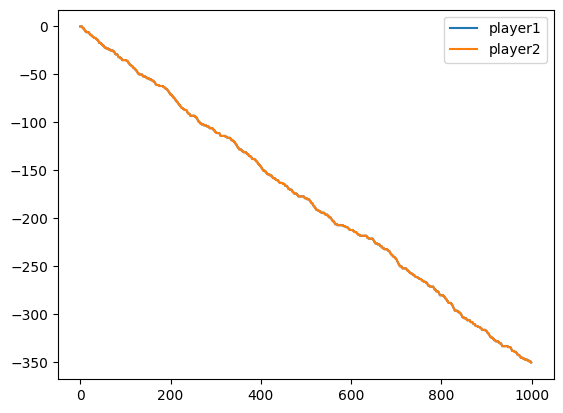

In [6]:
#@title Case - both always play
episodes = 1000

episode_rews = []

for _ in range(episodes):

    obs = env.reset()
    while env.agents:
        acts = {
            "player1": 1,
            "player2": 1
        }

        obs, rews, terms, truncs, infos = env.step(acts)
        # print(obs, rews)

    episode_rews.append([rews['player1'], rews['player2']])

arr = np.array(episode_rews)

interval_size = 100
num_intervals = episodes // interval_size

means = []
std_devs = []

for i in range(0, episodes, interval_size):
    interval_data = arr[i:i+interval_size]
    mean = np.mean(interval_data, axis=0)
    means.append(mean)

for i in range(num_intervals - 1):
    mean_diff = means[i+1] - means[i]
    std_devs.append(mean_diff)

avg = (np.mean(arr, axis=0)) * -100
std_dev = np.std(std_devs, axis=0) * 100

print(f"death rate (in %) of player1: {avg[0]:.1f} +- {std_dev[0]:.3f}")
print(f"death rate (in %) of player2: {avg[1]:.1f} +- {std_dev[1]:.3f}")

plt.plot(arr.cumsum(axis=0))
plt.legend(("player1", "player2"))
plt.show()

death rate (in %) of player1: 61.4 +- 5.965
death rate (in %) of player2: 61.4 +- 5.965


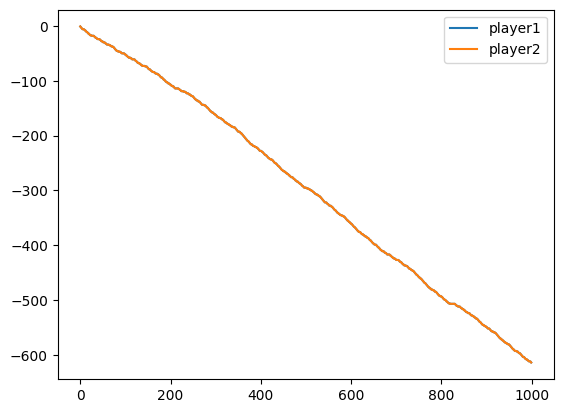

In [7]:
#@title Case - both always wait
episodes = 1000

episode_rews = []

for _ in range(episodes):

    obs = env.reset()
    while env.agents:
        acts = {
            "player1": 0,
            "player2": 0
        }

        obs, rews, terms, truncs, infos = env.step(acts)
        # print(obs, rews)

    episode_rews.append([rews['player1'], rews['player2']])

arr = np.array(episode_rews)
interval_size = 100
num_intervals = episodes // interval_size

means = []
std_devs = []

for i in range(0, episodes, interval_size):
    interval_data = arr[i:i+interval_size]
    mean = np.mean(interval_data, axis=0)
    means.append(mean)

for i in range(num_intervals - 1):
    mean_diff = means[i+1] - means[i]
    std_devs.append(mean_diff)

avg = (np.mean(arr, axis=0)) * -100
std_dev = np.std(std_devs, axis=0) * 100

print(f"death rate (in %) of player1: {avg[0]:.1f} +- {std_dev[0]:.3f}")
print(f"death rate (in %) of player2: {avg[1]:.1f} +- {std_dev[1]:.3f}")
plt.plot(arr.cumsum(axis=0))
plt.legend(("player1", "player2"))
plt.show()

death rate (in %) of player1: 64.2 +- 8.144
death rate (in %) of player2: 71.3 +- 7.992


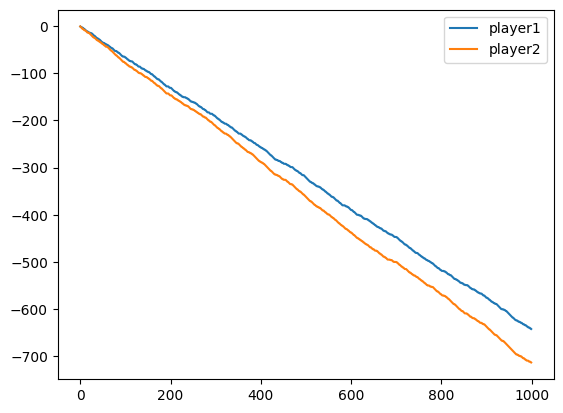

In [8]:
#@title Case - player1 waits, player2 plays
episodes = 1000

episode_rews = []

for _ in range(episodes):

    obs = env.reset()
    while env.agents:
        acts = {
            "player1": 0,
            "player2": 1
        }

        obs, rews, terms, truncs, infos = env.step(acts)
        # print(obs, rews)

    episode_rews.append([rews['player1'], rews['player2']])

arr = np.array(episode_rews)
interval_size = 100
num_intervals = episodes // interval_size

means = []
std_devs = []

for i in range(0, episodes, interval_size):
    interval_data = arr[i:i+interval_size]
    mean = np.mean(interval_data, axis=0)
    means.append(mean)

for i in range(num_intervals - 1):
    mean_diff = means[i+1] - means[i]
    std_devs.append(mean_diff)

avg = (np.mean(arr, axis=0)) * -100
std_dev = np.std(std_devs, axis=0) * 100

print(f"death rate (in %) of player1: {avg[0]:.1f} +- {std_dev[0]:.3f}")
print(f"death rate (in %) of player2: {avg[1]:.1f} +- {std_dev[1]:.3f}")
plt.plot(arr.cumsum(axis=0))
plt.legend(("player1", "player2"))
plt.show()

death rate (in %) of player1: 68.2 +- 5.363
death rate (in %) of player2: 60.3 +- 7.846


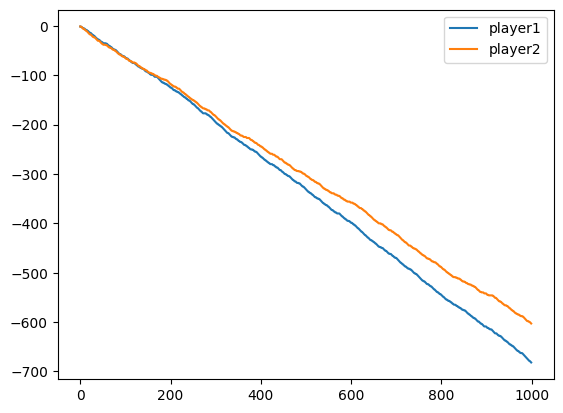

In [9]:
#@title Case - player1 plays, player2 waits
episodes = 1000

episode_rews = []

for _ in range(episodes):

    obs = env.reset()
    while env.agents:
        acts = {
            "player1": 1,
            "player2": 0
        }

        obs, rews, terms, truncs, infos = env.step(acts)
        # print(obs, rews)

    episode_rews.append([rews['player1'], rews['player2']])

arr = np.array(episode_rews)
interval_size = 100
num_intervals = episodes // interval_size

means = []
std_devs = []

for i in range(0, episodes, interval_size):
    interval_data = arr[i:i+interval_size]
    mean = np.mean(interval_data, axis=0)
    means.append(mean)

for i in range(num_intervals - 1):
    mean_diff = means[i+1] - means[i]
    std_devs.append(mean_diff)

avg = (np.mean(arr, axis=0)) * -100
std_dev = np.std(std_devs, axis=0) * 100

print(f"death rate (in %) of player1: {avg[0]:.1f} +- {std_dev[0]:.3f}")
print(f"death rate (in %) of player2: {avg[1]:.1f} +- {std_dev[1]:.3f}")
plt.plot(arr.cumsum(axis=0))
plt.legend(("player1", "player2"))
plt.show()

death rate (in %) of player1: 57.1 +- 6.000
death rate (in %) of player2: 49.1 +- 3.232


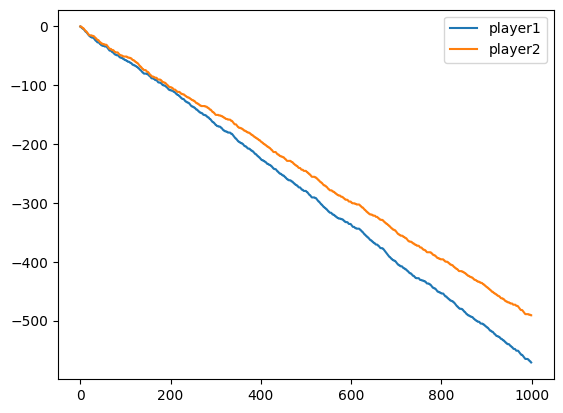

In [10]:
#@title Case - Always play vs random agent
episodes = 1000

episode_rews = []

for _ in range(episodes):

    obs = env.reset()
    while env.agents:
        acts = {
            "player1": 1,
            "player2": np.random.choice([0, 1])
        }

        obs, rews, terms, truncs, infos = env.step(acts)
        # print(obs, rews)

    episode_rews.append([rews['player1'], rews['player2']])

arr = np.array(episode_rews)
interval_size = 100
num_intervals = episodes // interval_size

means = []
std_devs = []

for i in range(0, episodes, interval_size):
    interval_data = arr[i:i+interval_size]
    mean = np.mean(interval_data, axis=0)
    means.append(mean)

for i in range(num_intervals - 1):
    mean_diff = means[i+1] - means[i]
    std_devs.append(mean_diff)

avg = (np.mean(arr, axis=0)) * -100
std_dev = np.std(std_devs, axis=0) * 100

print(f"death rate (in %) of player1: {avg[0]:.1f} +- {std_dev[0]:.3f}")
print(f"death rate (in %) of player2: {avg[1]:.1f} +- {std_dev[1]:.3f}")
plt.plot(arr.cumsum(axis=0))
plt.legend(("player1", "player2"))
plt.show()

death rate (in %) of player1: 62.1 +- 6.784
death rate (in %) of player2: 66.1 +- 6.733


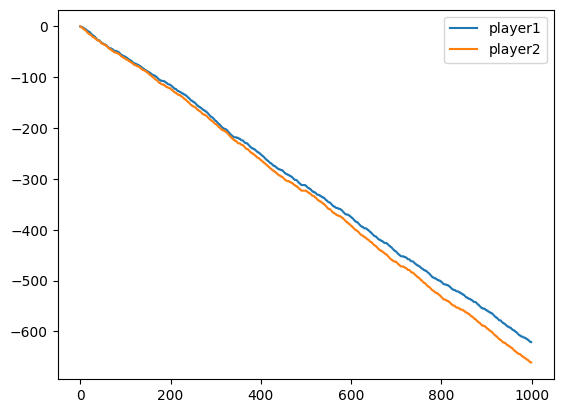

In [11]:
#@title Case - Always wait vs random agent
episodes = 1000

episode_rews = []

for _ in range(episodes):

    obs = env.reset()
    while env.agents:
        acts = {
            "player1": 0,
            "player2": np.random.choice([0, 1])
        }

        obs, rews, terms, truncs, infos = env.step(acts)
        # print(obs, rews)

    episode_rews.append([rews['player1'], rews['player2']])

arr = np.array(episode_rews)
interval_size = 100
num_intervals = episodes // interval_size

means = []
std_devs = []

for i in range(0, episodes, interval_size):
    interval_data = arr[i:i+interval_size]
    mean = np.mean(interval_data, axis=0)
    means.append(mean)

for i in range(num_intervals - 1):
    mean_diff = means[i+1] - means[i]
    std_devs.append(mean_diff)

avg = (np.mean(arr, axis=0)) * -100
std_dev = np.std(std_devs, axis=0) * 100

print(f"death rate (in %) of player1: {avg[0]:.1f} +- {std_dev[0]:.3f}")
print(f"death rate (in %) of player2: {avg[1]:.1f} +- {std_dev[1]:.3f}")
plt.plot(arr.cumsum(axis=0))
plt.legend(("player1", "player2"))
plt.show()

death rate (in %) of player1: 66.2 +- 7.885
death rate (in %) of player2: 45.8 +- 5.021


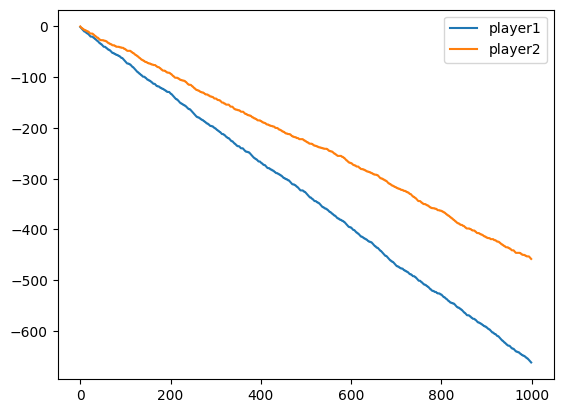

In [12]:
#@title Case - Always play vs hail mary
episodes = 1000

episode_rews = []

for _ in range(episodes):

    obs = env.reset()
    while env.agents:
        acts = {
            "player1": 1,
            "player2": 1 if obs["player2"]["observation"][0, 2] <= 1 else 0
        }

        obs, rews, terms, truncs, infos = env.step(acts)
        # print(obs, rews)

    episode_rews.append([rews['player1'], rews['player2']])

arr = np.array(episode_rews)
interval_size = 100
num_intervals = episodes // interval_size

means = []
std_devs = []

for i in range(0, episodes, interval_size):
    interval_data = arr[i:i+interval_size]
    mean = np.mean(interval_data, axis=0)
    means.append(mean)

for i in range(num_intervals - 1):
    mean_diff = means[i+1] - means[i]
    std_devs.append(mean_diff)

avg = (np.mean(arr, axis=0)) * -100
std_dev = np.std(std_devs, axis=0) * 100

print(f"death rate (in %) of player1: {avg[0]:.1f} +- {std_dev[0]:.3f}")
print(f"death rate (in %) of player2: {avg[1]:.1f} +- {std_dev[1]:.3f}")
plt.plot(arr.cumsum(axis=0))
plt.legend(("player1", "player2"))
plt.show()

death rate (in %) of player1: 61.9 +- 7.040
death rate (in %) of player2: 52.8 +- 8.743


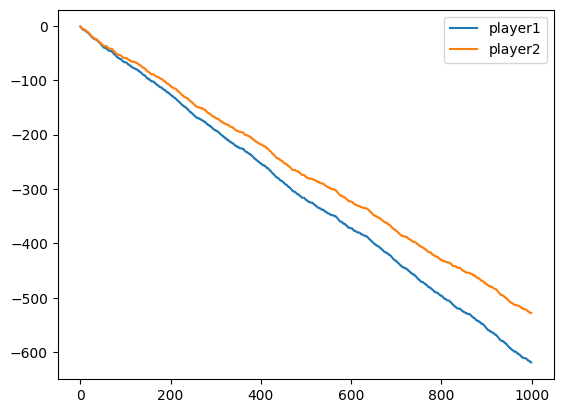

In [13]:
#@title Case - Always wait vs hail mary
episodes = 1000

episode_rews = []

for _ in range(episodes):

    obs = env.reset()
    while env.agents:
        acts = {
            "player1": 0,
            "player2": 1 if obs["player2"]["observation"][0, 2] <= 1 else 0
        }

        obs, rews, terms, truncs, infos = env.step(acts)
        # print(obs, rews)

    episode_rews.append([rews['player1'], rews['player2']])

arr = np.array(episode_rews)
interval_size = 100
num_intervals = episodes // interval_size

means = []
std_devs = []

for i in range(0, episodes, interval_size):
    interval_data = arr[i:i+interval_size]
    mean = np.mean(interval_data, axis=0)
    means.append(mean)

for i in range(num_intervals - 1):
    mean_diff = means[i+1] - means[i]
    std_devs.append(mean_diff)

avg = (np.mean(arr, axis=0)) * -100
std_dev = np.std(std_devs, axis=0) * 100

print(f"death rate (in %) of player1: {avg[0]:.1f} +- {std_dev[0]:.3f}")
print(f"death rate (in %) of player2: {avg[1]:.1f} +- {std_dev[1]:.3f}")
plt.plot(arr.cumsum(axis=0))
plt.legend(("player1", "player2"))
plt.show()

In [14]:
#@title Load optimal policy

# def optimal(obs):
#     df = pd.read_csv("models/optimal_policy.csv")
#     return df.loc[
#         (df["days_left"] == obs["player1"]["observation"][0][0]) &
#         (df["player1_life_points"] == obs["player1"]["observation"][0][1]) &
#         (df["player2_life_points"] == obs["player1"]["observation"][0][2]) &
#         (df["player1_prob_payoff"] == obs["player1"]["observation"][0][3])
#     ]["action"].values[0] - 1

In [15]:
#@title Visualize optimal policy

# df = pd.read_csv("models/optimal_policy.csv")

# fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)

# arr = df.loc[(df["days_left"] == 1) & 
#     (df["player1_life_points"] > 0.5) & 
#     (df["player2_life_points"] > 0.5) & (df["player1_prob_payoff"] < 0.3), "action"].values

# ax1.imshow(np.reshape(arr, (3, 3)), cmap='bwr')
# ax1.set_title("Day->1 Env->Bad")
# ax1.set_xticks([0, 1, 2], [1, 2, 3])
# ax1.set_yticks([0, 1, 2], [1, 2, 3])

# arr = df.loc[(df["days_left"] == 2) & 
#     (df["player1_life_points"] > 0.5) & 
#     (df["player2_life_points"] > 0.5) & (df["player1_prob_payoff"] < 0.3), "action"].values

# ax2.imshow(np.reshape(arr, (3, 3)), cmap='bwr')
# ax2.set_title("Day->2 Env->Bad")
# ax2.set_xticks([0, 1, 2], [1, 2, 3])
# ax2.set_yticks([0, 1, 2], [1, 2, 3])

# arr = df.loc[(df["days_left"] == 1) & 
#     (df["player1_life_points"] > 0.5) & 
#     (df["player2_life_points"] > 0.5) & (df["player1_prob_payoff"] > 0.3), "action"].values

# ax3.imshow(np.reshape(arr, (3, 3)), cmap='bwr')
# ax3.set_title("Day->1 Env->Good")
# ax3.set_xticks([0, 1, 2], [1, 2, 3])
# ax3.set_yticks([0, 1, 2], [1, 2, 3])

# arr = df.loc[(df["days_left"] == 2) & 
#     (df["player1_life_points"] > 0.5) & 
#     (df["player2_life_points"] > 0.5) & (df["player1_prob_payoff"] > 0.3), "action"].values

# ax = ax4.imshow(np.reshape(arr, (3, 3)), cmap='bwr')
# ax4.set_title("Day->2 Env->Good")
# ax4.set_xticks([0, 1, 2], [1, 2, 3])
# ax4.set_yticks([0, 1, 2], [1, 2, 3])
# ax4.set_xlabel("player2_life_points")
# ax4.set_ylabel("player1_life_points")

# red_patch = mpatches.Patch(color='red', label='Play')
# blue_patch = mpatches.Patch(color='blue', label='Wait')

# plt.legend(handles=[red_patch, blue_patch])

# fig.tight_layout()
# plt.show()

In [16]:
#@title Case - optimal vs Always wait
# episodes = 1000

# episode_rews = []

# for _ in range(episodes):

#     obs = env.reset()
#     while env.agents:
#         acts = {
#             "player1": optimal(obs),
#             "player2": 0
#         }

#         obs, rews, terms, truncs, infos = env.step(acts)
#         # print(obs, rews)

#     episode_rews.append([rews['player1'], rews['player2']])

# arr = np.array(episode_rews)
# interval_size = 100
# num_intervals = episodes // interval_size

# means = []
# std_devs = []

# for i in range(0, episodes, interval_size):
#     interval_data = arr[i:i+interval_size]
#     mean = np.mean(interval_data, axis=0)
#     means.append(mean)

# for i in range(num_intervals - 1):
#     mean_diff = means[i+1] - means[i]
#     std_devs.append(mean_diff)

# avg = (np.mean(arr, axis=0)) * -100
# std_dev = np.std(std_devs, axis=0) * 100

# print(f"death rate (in %) of player1: {avg[0]:.1f} +- {std_dev[0]:.3f}")
# print(f"death rate (in %) of player2: {avg[1]:.1f} +- {std_dev[1]:.3f}")
# plt.plot(arr.cumsum(axis=0))
# plt.legend(("player1", "player2"))
# plt.show()

In [17]:
#@title Case - optimal vs Always play
# episodes = 1000

# episode_rews = []

# for _ in range(episodes):

#     obs = env.reset()
#     while env.agents:
#         acts = {
#             "player1": optimal(obs), 
#             "player2": 0
#         }

#         obs, rews, terms, truncs, infos = env.step(acts)
#         # print(obs, rews)

#     episode_rews.append([rews['player1'], rews['player2']])

# arr = np.array(episode_rews)
# interval_size = 100
# num_intervals = episodes // interval_size

# means = []
# std_devs = []

# for i in range(0, episodes, interval_size):
#     interval_data = arr[i:i+interval_size]
#     mean = np.mean(interval_data, axis=0)
#     means.append(mean)

# for i in range(num_intervals - 1):
#     mean_diff = means[i+1] - means[i]
#     std_devs.append(mean_diff)

# avg = (np.mean(arr, axis=0)) * -100
# std_dev = np.std(std_devs, axis=0) * 100

# print(f"death rate (in %) of player1: {avg[0]:.1f} +- {std_dev[0]:.3f}")
# print(f"death rate (in %) of player2: {avg[1]:.1f} +- {std_dev[1]:.3f}")
# plt.plot(arr.cumsum(axis=0))
# plt.legend(("player1", "player2"))
# plt.show()

In [18]:
#@title Case - optimal vs hail mary
# episodes = 1000

# episode_rews = []

# for _ in range(episodes):

#     obs = env.reset()
#     while env.agents:
#         acts = {
#             "player1": optimal(obs),
#             "player2": 1 if obs["player2"]["observation"][0, 2] <= 1 else 0
#         }

#         obs, rews, terms, truncs, infos = env.step(acts)
#         # print(obs, rews)

#     episode_rews.append([rews['player1'], rews['player2']])

# arr = np.array(episode_rews)
# interval_size = 100
# num_intervals = episodes // interval_size

# means = []
# std_devs = []

# for i in range(0, episodes, interval_size):
#     interval_data = arr[i:i+interval_size]
#     mean = np.mean(interval_data, axis=0)
#     means.append(mean)

# for i in range(num_intervals - 1):
#     mean_diff = means[i+1] - means[i]
#     std_devs.append(mean_diff)

# avg = (np.mean(arr, axis=0)) * -100
# std_dev = np.std(std_devs, axis=0) * 100

# print(f"death rate (in %) of player1: {avg[0]:.1f} +- {std_dev[0]:.3f}")
# print(f"death rate (in %) of player2: {avg[1]:.1f} +- {std_dev[1]:.3f}")
# plt.plot(arr.cumsum(axis=0))
# plt.legend(("player1", "player2"))
# plt.show()

In [19]:
#@title Case - optimal vs optimal
# episodes = 1000

# episode_rews = []

# for _ in range(episodes):

#     obs = env.reset()
#     while env.agents:
#         acts = {
#             "player1": optimal(obs),
#             "player2": optimal(obs)
#         }

#         obs, rews, terms, truncs, infos = env.step(acts)
#         # print(obs, rews)

#     episode_rews.append([rews['player1'], rews['player2']])

# arr = np.array(episode_rews)
# interval_size = 100
# num_intervals = episodes // interval_size

# means = []
# std_devs = []

# for i in range(0, episodes, interval_size):
#     interval_data = arr[i:i+interval_size]
#     mean = np.mean(interval_data, axis=0)
#     means.append(mean)

# for i in range(num_intervals - 1):
#     mean_diff = means[i+1] - means[i]
#     std_devs.append(mean_diff)

# avg = (np.mean(arr, axis=0)) * -100
# std_dev = np.std(std_devs, axis=0) * 100

# print(f"death rate (in %) of player1: {avg[0]:.1f} +- {std_dev[0]:.3f}")
# print(f"death rate (in %) of player2: {avg[1]:.1f} +- {std_dev[1]:.3f}")
# plt.plot(arr.cumsum(axis=0))
# plt.legend(("player1", "player2"))
# plt.show()

## Deep RL training


In [20]:
#@title Define heuristic algos in Tianshou
## agent that always plays
class AlwaysPlay(BasePolicy):
    def __init__(self, **kwargs):
        self.nolearn = True
        super().__init__(**kwargs)
    
    def forward(self, batch, state = None):
        mask = batch.obs.mask
        logits = np.zeros(mask.shape)
        logits[:, 1] = 1
        logits[~mask] = -np.inf
        return Batch(act=logits.argmax(axis=-1))

    def learn(self, batch):
        return {}

## agent that always waits
class AlwaysWait(BasePolicy):
    def __init__(self, **kwargs):
        self.nolearn = True
        super().__init__(**kwargs)

    def forward(self, batch, state = None):
        mask = batch.obs.mask
        logits = np.zeros(mask.shape)
        logits[:, 0] = 1
        logits[~mask] = -np.inf
        return Batch(act=logits.argmax(axis=-1))

    def learn(self, batch):
        return {}

## agent that waits for low health to play
class HailMary(BasePolicy):
    def __init__(self, **kwargs):
        self.nolearn = True
        super().__init__(**kwargs)

    def forward(self, batch, state = None):
        mask = batch.obs.mask
        logits = np.zeros(mask.shape)
        obs = batch.obs.obs

        for i in range(mask.shape[0]):
            if obs[i, :, 2] <= 1:
                logits[i, 1] = 1
            else:
                logits[i, 0] = 1
        logits[~mask] = -np.inf
        return Batch(act=logits.argmax(axis=-1))

    def learn(self, batch):
        return {}

## optimal agent 
class OptimalPolicy(BasePolicy):
    def __init__(self, **kwargs):
        self.nolearn = True
        super().__init__(**kwargs)

    def forward(self, batch, state = None):
        mask = batch.obs.mask
        logits = np.zeros(mask.shape)
        obs = batch.obs.obs

        df = pd.read_csv("models/optimal_policy.csv")

        for i in range(mask.shape[0]):
            action = df.loc[
                (df["days_left"] == obs[i, :, 0][0]) &
                (df["player1_life_points"] == obs[i, :, 1][0]) &
                (df["player2_life_points"] == obs[i, :, 2][0]) &
                (df["player1_prob_payoff"] == obs[i, :, 3][0])
            ]["action"].values[0] - 1
            if action:
                logits[i, 1] = 1
            else:
                logits[i, 0] = 1
        logits[~mask] = -np.inf
        return Batch(act=logits.argmax(axis=-1))

    def learn(self, batch):
        return {}

## random agent
class RandomAgent(BasePolicy):
    def __init__(self, **kwargs):
        self.nolearn = True
        super().__init__(**kwargs)

    def forward(self, batch, state = None):
        mask = batch.obs.mask
        logits = np.zeros(mask.shape)
        logits[:, np.random.choice([0, 1])] = 1
        logits[~mask] = -np.inf
        return Batch(act=logits.argmax(axis=-1))

    def learn(self, batch):
        return {}

In [21]:
#@title Prerequisites for training
# Step 2: Wrap the environment for Tianshou interfacing
def _get_env_train():
    env = HomMul(include_all_states=True)
    vec_env = parallel_to_aec(env)
    return PettingZooEnv(vec_env)

def _get_env_test():
    env = HomMul(include_all_states=True)
    vec_env = parallel_to_aec(env)
    return PettingZooEnv(vec_env)

# seed
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

env = HomMul()
agents =  env.agents[:]

# Step 3: Define policies for each agent
## learning agent
def _get_agent(pretrained=False):
    vec_env = _get_env_train()
    net = Net(
        state_shape=vec_env.observation_space.shape,
        action_shape=vec_env.action_space.n,
        hidden_sizes=[128, 128],
        device="cuda",
    ).to("cuda")
    optim = Adam(net.parameters(), lr=1e-4)
    model = DQNPolicy(
        model=net,
        optim=optim,
        discount_factor=0.9,
        estimation_step=3,
        target_update_freq=50,
    )

    if pretrained:
        model_save_path = os.path.join("models", "vs_hail_mary.pth")
        model.load_state_dict(torch.load(model_save_path))
    return model

agent_learn1 = _get_agent(pretrained=False)
agent_learn2 = _get_agent(pretrained=False)

train_policies = MultiAgentPolicyManager([agent_learn1, agent_learn2],  _get_env_train())

train_envs = DummyVectorEnv([_get_env_train for _ in range(10)])
test_envs = DummyVectorEnv([_get_env_test for _ in range(2)])
train_envs.seed(seed)
test_envs.seed(seed)

# Step 4: Collector setup
train_collector = Collector(
    train_policies,
    train_envs,
    VectorReplayBuffer(20_000, len(train_envs)),
    exploration_noise=True,
)

test_policies = MultiAgentPolicyManager([agent_learn1, agent_learn2],  _get_env_test())
test_collector = Collector(test_policies, test_envs, exploration_noise=True)

train_collector.collect(n_episode=50)

def save_best_fn(policy):
    model_save_path1 = os.path.join("log", "hommul", "dqn", "policy1.pth")
    model_save_path2 = os.path.join("log", "hommul", "dqn", "policy2.pth")
    os.makedirs(os.path.join("log", "hommul", "dqn"), exist_ok=True)
    if not hasattr(train_policies.policies[agents[0]], 'nolearn'):
        torch.save(train_policies.policies[agents[0]].state_dict(), model_save_path1)
    if not hasattr(train_policies.policies[agents[1]], 'nolearn'):
        torch.save(train_policies.policies[agents[1]].state_dict(), model_save_path2)

def stop_fn(mean_rewards):
    return mean_rewards >= -0.05

def train_fn(epoch, env_step):
    # freeze training for player1
    if not hasattr(train_policies.policies[agents[0]], 'nolearn'):
        train_policies.policies[agents[0]].set_eps(0.05)

    if not hasattr(train_policies.policies[agents[1]], 'nolearn'):
        train_policies.policies[agents[1]].set_eps(0.1)

def test_fn(epoch, env_step):
    if not hasattr(train_policies.policies[agents[0]], 'nolearn'):
        train_policies.policies[agents[0]].set_eps(0.05)

    if not hasattr(train_policies.policies[agents[1]], 'nolearn'):
        train_policies.policies[agents[1]].set_eps(0.05)

def reward_metric(rews):
    return rews[:, 1]

In [22]:
#@title Clear logs and setup TensorBoard
!rm -rf /content/HomMul/log

log_path = os.path.join("log", "hommul", "dqn")
writer = SummaryWriter(log_path)
logger = TensorboardLogger(writer)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


#### Evolution 1


Epoch #1: 1001it [00:03, 305.48it/s, env_step=1000, len=6, n/ep=7, n/st=50, player1/loss=0.118, player2/loss=0.280, rew=-0.43]                          


Epoch #1: test_reward: -0.560000 ± 0.496387, best_reward: -0.560000 ± 0.496387 in #1


Epoch #2: 1001it [00:01, 885.26it/s, env_step=2000, len=8, n/ep=8, n/st=50, player1/loss=0.099, player2/loss=0.187, rew=-0.75]                          


Epoch #2: test_reward: -0.580000 ± 0.493559, best_reward: -0.560000 ± 0.496387 in #1


Epoch #3: 1001it [00:01, 907.01it/s, env_step=3000, len=7, n/ep=10, n/st=50, player1/loss=0.089, player2/loss=0.177, rew=-0.70]                          


Epoch #3: test_reward: -0.550000 ± 0.497494, best_reward: -0.550000 ± 0.497494 in #3


Epoch #4: 1001it [00:01, 905.05it/s, env_step=4000, len=8, n/ep=12, n/st=50, player1/loss=0.078, player2/loss=0.189, rew=-0.58]                          


Epoch #4: test_reward: -0.550000 ± 0.497494, best_reward: -0.550000 ± 0.497494 in #3


Epoch #5: 1001it [00:01, 907.80it/s, env_step=5000, len=6, n/ep=7, n/st=50, player1/loss=0.094, player2/loss=0.183, rew=-0.57]                          


Epoch #5: test_reward: -0.450000 ± 0.497494, best_reward: -0.450000 ± 0.497494 in #5


Epoch #6: 1001it [00:01, 903.25it/s, env_step=6000, len=9, n/ep=7, n/st=50, player1/loss=0.099, player2/loss=0.198, rew=-0.71]                          


Epoch #6: test_reward: -0.510000 ± 0.499900, best_reward: -0.450000 ± 0.497494 in #5


Epoch #7: 1001it [00:01, 681.39it/s, env_step=7000, len=7, n/ep=10, n/st=50, player1/loss=0.099, player2/loss=0.220, rew=-0.60]                          


Epoch #7: test_reward: -0.440000 ± 0.496387, best_reward: -0.440000 ± 0.496387 in #7


Epoch #8: 1001it [00:01, 820.69it/s, env_step=8000, len=7, n/ep=10, n/st=50, player1/loss=0.112, player2/loss=0.215, rew=-0.60]                          


Epoch #8: test_reward: -0.520000 ± 0.499600, best_reward: -0.440000 ± 0.496387 in #7


Epoch #9: 1001it [00:01, 908.27it/s, env_step=9000, len=8, n/ep=4, n/st=50, player1/loss=0.121, player2/loss=0.234, rew=-0.75]                          


Epoch #9: test_reward: -0.580000 ± 0.493559, best_reward: -0.440000 ± 0.496387 in #7


Epoch #10: 1001it [00:01, 883.42it/s, env_step=10000, len=6, n/ep=5, n/st=50, player1/loss=0.118, player2/loss=0.243, rew=-0.60]                          


Epoch #10: test_reward: -0.470000 ± 0.499099, best_reward: -0.440000 ± 0.496387 in #7


Epoch #11: 1001it [00:01, 867.37it/s, env_step=11000, len=7, n/ep=10, n/st=50, player1/loss=0.127, player2/loss=0.267, rew=-0.40]                          


Epoch #11: test_reward: -0.460000 ± 0.498397, best_reward: -0.440000 ± 0.496387 in #7


Epoch #12: 1001it [00:01, 913.41it/s, env_step=12000, len=6, n/ep=8, n/st=50, player1/loss=0.145, player2/loss=0.277, rew=-0.62]                          


Epoch #12: test_reward: -0.600000 ± 0.489898, best_reward: -0.440000 ± 0.496387 in #7


Epoch #13: 1001it [00:01, 919.71it/s, env_step=13000, len=9, n/ep=10, n/st=50, player1/loss=0.148, player2/loss=0.264, rew=-0.60]                          


Epoch #13: test_reward: -0.490000 ± 0.499900, best_reward: -0.440000 ± 0.496387 in #7


Epoch #14: 1001it [00:01, 727.69it/s, env_step=14000, len=8, n/ep=9, n/st=50, player1/loss=0.164, player2/loss=0.297, rew=-0.67]                          


Epoch #14: test_reward: -0.510000 ± 0.499900, best_reward: -0.440000 ± 0.496387 in #7


Epoch #15: 1001it [00:01, 710.80it/s, env_step=15000, len=7, n/ep=9, n/st=50, player1/loss=0.155, player2/loss=0.304, rew=-0.44]                          


Epoch #15: test_reward: -0.580000 ± 0.493559, best_reward: -0.440000 ± 0.496387 in #7


Epoch #16: 1001it [00:01, 904.92it/s, env_step=16000, len=7, n/ep=8, n/st=50, player1/loss=0.177, player2/loss=0.295, rew=-0.62]                          


Epoch #16: test_reward: -0.410000 ± 0.491833, best_reward: -0.410000 ± 0.491833 in #16


Epoch #17: 1001it [00:01, 870.75it/s, env_step=17000, len=7, n/ep=8, n/st=50, player1/loss=0.168, player2/loss=0.319, rew=-0.62]                          


Epoch #17: test_reward: -0.490000 ± 0.499900, best_reward: -0.410000 ± 0.491833 in #16


Epoch #18: 1001it [00:01, 883.50it/s, env_step=18000, len=8, n/ep=7, n/st=50, player1/loss=0.194, player2/loss=0.327, rew=-0.57]                          


Epoch #18: test_reward: -0.450000 ± 0.497494, best_reward: -0.410000 ± 0.491833 in #16


Epoch #19: 1001it [00:01, 854.12it/s, env_step=19000, len=7, n/ep=6, n/st=50, player1/loss=0.195, player2/loss=0.322, rew=-0.50]                          


Epoch #19: test_reward: -0.490000 ± 0.499900, best_reward: -0.410000 ± 0.491833 in #16


Epoch #20: 1001it [00:01, 854.42it/s, env_step=20000, len=7, n/ep=7, n/st=50, player1/loss=0.196, player2/loss=0.335, rew=-0.57]                          


Epoch #20: test_reward: -0.520000 ± 0.499600, best_reward: -0.410000 ± 0.491833 in #16
##########

death rate (in %) of player1: 31.5 +- 7.789
death rate (in %) of player2: 31.2 +- 7.320


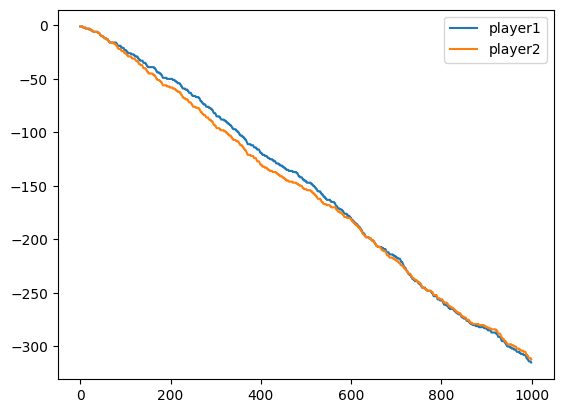


#### Evolution 2


Epoch #1: 1001it [00:01, 893.29it/s, env_step=1000, len=6, n/ep=9, n/st=50, player1/loss=0.177, player2/loss=0.314, rew=-0.11]                          


Epoch #1: test_reward: -0.570000 ± 0.495076, best_reward: -0.390000 ± 0.487750 in #0


Epoch #2: 1001it [00:01, 859.15it/s, env_step=2000, len=7, n/ep=5, n/st=50, player1/loss=0.121, player2/loss=0.302, rew=-0.60]                          


Epoch #2: test_reward: -0.370000 ± 0.482804, best_reward: -0.370000 ± 0.482804 in #2


Epoch #3: 1001it [00:01, 890.11it/s, env_step=3000, len=7, n/ep=11, n/st=50, player1/loss=0.124, player2/loss=0.310, rew=-0.36]                          


Epoch #3: test_reward: -0.510000 ± 0.499900, best_reward: -0.370000 ± 0.482804 in #2


Epoch #4: 1001it [00:01, 864.45it/s, env_step=4000, len=8, n/ep=9, n/st=50, player1/loss=0.124, player2/loss=0.353, rew=-0.56]                          


Epoch #4: test_reward: -0.530000 ± 0.499099, best_reward: -0.370000 ± 0.482804 in #2


Epoch #5: 1001it [00:01, 668.89it/s, env_step=5000, len=8, n/ep=5, n/st=50, player1/loss=0.113, player2/loss=0.350, rew=-0.60]                          


Epoch #5: test_reward: -0.530000 ± 0.499099, best_reward: -0.370000 ± 0.482804 in #2


Epoch #6: 1001it [00:01, 860.47it/s, env_step=6000, len=6, n/ep=11, n/st=50, player1/loss=0.111, player2/loss=0.363, rew=-0.36]                          


Epoch #6: test_reward: -0.480000 ± 0.499600, best_reward: -0.370000 ± 0.482804 in #2


Epoch #7: 1001it [00:01, 889.69it/s, env_step=7000, len=8, n/ep=8, n/st=50, player1/loss=0.117, player2/loss=0.348, rew=-0.50]                          


Epoch #7: test_reward: -0.460000 ± 0.498397, best_reward: -0.370000 ± 0.482804 in #2


Epoch #8: 1001it [00:01, 861.24it/s, env_step=8000, len=8, n/ep=7, n/st=50, player1/loss=0.128, player2/loss=0.353, rew=-0.57]                          


Epoch #8: test_reward: -0.630000 ± 0.482804, best_reward: -0.370000 ± 0.482804 in #2


Epoch #9: 1001it [00:01, 853.15it/s, env_step=9000, len=7, n/ep=8, n/st=50, player1/loss=0.138, player2/loss=0.384, rew=-0.62]                          


Epoch #9: test_reward: -0.530000 ± 0.499099, best_reward: -0.370000 ± 0.482804 in #2


Epoch #10: 1001it [00:01, 876.44it/s, env_step=10000, len=7, n/ep=8, n/st=50, player1/loss=0.140, player2/loss=0.402, rew=-0.38]                          


Epoch #10: test_reward: -0.550000 ± 0.497494, best_reward: -0.370000 ± 0.482804 in #2


Epoch #11: 1001it [00:01, 872.97it/s, env_step=11000, len=7, n/ep=6, n/st=50, player1/loss=0.117, player2/loss=0.376, rew=-0.33]                          


Epoch #11: test_reward: -0.570000 ± 0.495076, best_reward: -0.370000 ± 0.482804 in #2


Epoch #12: 1001it [00:01, 674.56it/s, env_step=12000, len=6, n/ep=8, n/st=50, player1/loss=0.131, player2/loss=0.386, rew=-0.38]                          


Epoch #12: test_reward: -0.450000 ± 0.497494, best_reward: -0.370000 ± 0.482804 in #2


Epoch #13: 1001it [00:01, 866.66it/s, env_step=13000, len=7, n/ep=9, n/st=50, player1/loss=0.132, player2/loss=0.384, rew=-0.44]                          


Epoch #13: test_reward: -0.430000 ± 0.495076, best_reward: -0.370000 ± 0.482804 in #2


Epoch #14: 1001it [00:01, 860.80it/s, env_step=14000, len=5, n/ep=6, n/st=50, player1/loss=0.129, player2/loss=0.395, rew=-0.17]                          


Epoch #14: test_reward: -0.350000 ± 0.476970, best_reward: -0.350000 ± 0.476970 in #14


Epoch #15: 1001it [00:01, 881.29it/s, env_step=15000, len=7, n/ep=5, n/st=50, player1/loss=0.137, player2/loss=0.415, rew=-0.60]                          


Epoch #15: test_reward: -0.470000 ± 0.499099, best_reward: -0.350000 ± 0.476970 in #14


Epoch #16: 1001it [00:01, 908.17it/s, env_step=16000, len=9, n/ep=11, n/st=50, player1/loss=0.136, player2/loss=0.427, rew=-0.82]                          


Epoch #16: test_reward: -0.400000 ± 0.489898, best_reward: -0.350000 ± 0.476970 in #14


Epoch #17: 1001it [00:01, 929.95it/s, env_step=17000, len=8, n/ep=9, n/st=50, player1/loss=0.139, player2/loss=0.415, rew=-0.44]                          


Epoch #17: test_reward: -0.550000 ± 0.497494, best_reward: -0.350000 ± 0.476970 in #14


Epoch #18: 1001it [00:01, 891.06it/s, env_step=18000, len=10, n/ep=6, n/st=50, player1/loss=0.136, player2/loss=0.431, rew=-0.83]                          


Epoch #18: test_reward: -0.420000 ± 0.493559, best_reward: -0.350000 ± 0.476970 in #14


Epoch #19: 1001it [00:01, 684.55it/s, env_step=19000, len=10, n/ep=6, n/st=50, player1/loss=0.158, player2/loss=0.464, rew=-1.00]                          


Epoch #19: test_reward: -0.450000 ± 0.497494, best_reward: -0.350000 ± 0.476970 in #14


Epoch #20: 1001it [00:01, 834.17it/s, env_step=20000, len=8, n/ep=7, n/st=50, player1/loss=0.124, player2/loss=0.425, rew=-0.14]                          


Epoch #20: test_reward: -0.450000 ± 0.497494, best_reward: -0.350000 ± 0.476970 in #14
##########

death rate (in %) of player1: 29.4 +- 7.608
death rate (in %) of player2: 27.9 +- 8.324


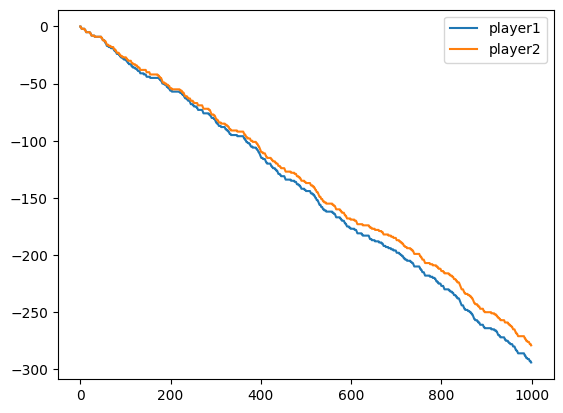


#### Evolution 3


Epoch #1: 1001it [00:01, 860.57it/s, env_step=1000, len=7, n/ep=8, n/st=50, player1/loss=0.321, player2/loss=0.463, rew=-0.62]                          


Epoch #1: test_reward: -0.500000 ± 0.500000, best_reward: -0.300000 ± 0.458258 in #0


Epoch #2: 1001it [00:01, 550.00it/s, env_step=2000, len=8, n/ep=6, n/st=50, player1/loss=0.219, player2/loss=0.490, rew=-0.67]                          


Epoch #2: test_reward: -0.390000 ± 0.487750, best_reward: -0.300000 ± 0.458258 in #0


Epoch #3: 1001it [00:01, 785.98it/s, env_step=3000, len=10, n/ep=6, n/st=50, player1/loss=0.205, player2/loss=0.463, rew=-0.83]                          


Epoch #3: test_reward: -0.430000 ± 0.495076, best_reward: -0.300000 ± 0.458258 in #0


Epoch #4: 1001it [00:01, 886.93it/s, env_step=4000, len=7, n/ep=6, n/st=50, player1/loss=0.197, player2/loss=0.419, rew=-0.67]                          


Epoch #4: test_reward: -0.350000 ± 0.476970, best_reward: -0.300000 ± 0.458258 in #0


Epoch #5: 1001it [00:01, 853.53it/s, env_step=5000, len=9, n/ep=8, n/st=50, player1/loss=0.188, player2/loss=0.424, rew=-0.25]                          


Epoch #5: test_reward: -0.500000 ± 0.500000, best_reward: -0.300000 ± 0.458258 in #0


Epoch #6: 1001it [00:01, 872.87it/s, env_step=6000, len=5, n/ep=5, n/st=50, player1/loss=0.206, player2/loss=0.418, rew=-0.20]                          


Epoch #6: test_reward: -0.320000 ± 0.466476, best_reward: -0.300000 ± 0.458258 in #0


Epoch #7: 1001it [00:01, 886.89it/s, env_step=7000, len=9, n/ep=8, n/st=50, player1/loss=0.211, player2/loss=0.459, rew=-0.62]                          


Epoch #7: test_reward: -0.550000 ± 0.497494, best_reward: -0.300000 ± 0.458258 in #0


Epoch #8: 1001it [00:01, 888.65it/s, env_step=8000, len=8, n/ep=11, n/st=50, player1/loss=0.219, player2/loss=0.381, rew=-0.45]                          


Epoch #8: test_reward: -0.510000 ± 0.499900, best_reward: -0.300000 ± 0.458258 in #0


Epoch #9: 1001it [00:01, 714.31it/s, env_step=9000, len=10, n/ep=8, n/st=50, player1/loss=0.211, player2/loss=0.403, rew=-0.50]                          


Epoch #9: test_reward: -0.470000 ± 0.499099, best_reward: -0.300000 ± 0.458258 in #0


Epoch #10: 1001it [00:01, 727.60it/s, env_step=10000, len=6, n/ep=6, n/st=50, player1/loss=0.226, player2/loss=0.414, rew=-0.33]                          


Epoch #10: test_reward: -0.420000 ± 0.493559, best_reward: -0.300000 ± 0.458258 in #0


Epoch #11: 1001it [00:01, 875.42it/s, env_step=11000, len=6, n/ep=8, n/st=50, player1/loss=0.205, player2/loss=0.437, rew=-0.12]                          


Epoch #11: test_reward: -0.330000 ± 0.470213, best_reward: -0.300000 ± 0.458258 in #0


Epoch #12: 1001it [00:01, 881.70it/s, env_step=12000, len=7, n/ep=7, n/st=50, player1/loss=0.209, player2/loss=0.474, rew=-0.43]                          


Epoch #12: test_reward: -0.390000 ± 0.487750, best_reward: -0.300000 ± 0.458258 in #0


Epoch #13: 1001it [00:01, 886.35it/s, env_step=13000, len=5, n/ep=5, n/st=50, player1/loss=0.203, player2/loss=0.403, rew=-0.20]                          


Epoch #13: test_reward: -0.300000 ± 0.458258, best_reward: -0.300000 ± 0.458258 in #0


Epoch #14: 1001it [00:01, 891.86it/s, env_step=14000, len=10, n/ep=10, n/st=50, player1/loss=0.201, player2/loss=0.483, rew=-0.70]                          


Epoch #14: test_reward: -0.450000 ± 0.497494, best_reward: -0.300000 ± 0.458258 in #0


Epoch #15: 1001it [00:01, 901.55it/s, env_step=15000, len=4, n/ep=9, n/st=50, player1/loss=0.206, player2/loss=0.529, rew=-0.33]                          


Epoch #15: test_reward: -0.390000 ± 0.487750, best_reward: -0.300000 ± 0.458258 in #0


Epoch #16: 1001it [00:01, 781.14it/s, env_step=16000, len=8, n/ep=8, n/st=50, player1/loss=0.221, player2/loss=0.500, rew=-0.50]                          


Epoch #16: test_reward: -0.530000 ± 0.499099, best_reward: -0.300000 ± 0.458258 in #0


Epoch #17: 1001it [00:01, 704.30it/s, env_step=17000, len=6, n/ep=12, n/st=50, player1/loss=0.236, player2/loss=0.613, rew=-0.42]                          


Epoch #17: test_reward: -0.510000 ± 0.499900, best_reward: -0.300000 ± 0.458258 in #0


Epoch #18: 1001it [00:01, 848.26it/s, env_step=18000, len=9, n/ep=9, n/st=50, player1/loss=0.223, player2/loss=0.595, rew=-0.78]                          


Epoch #18: test_reward: -0.450000 ± 0.497494, best_reward: -0.300000 ± 0.458258 in #0


Epoch #19: 1001it [00:01, 852.88it/s, env_step=19000, len=7, n/ep=7, n/st=50, player1/loss=0.212, player2/loss=0.617, rew=-0.14]                          


Epoch #19: test_reward: -0.390000 ± 0.487750, best_reward: -0.300000 ± 0.458258 in #0


Epoch #20: 1001it [00:01, 866.29it/s, env_step=20000, len=7, n/ep=10, n/st=50, player1/loss=0.211, player2/loss=0.672, rew=-0.50]                          


Epoch #20: test_reward: -0.270000 ± 0.443959, best_reward: -0.270000 ± 0.443959 in #20
##########

death rate (in %) of player1: 29.1 +- 8.116
death rate (in %) of player2: 27.9 +- 7.379


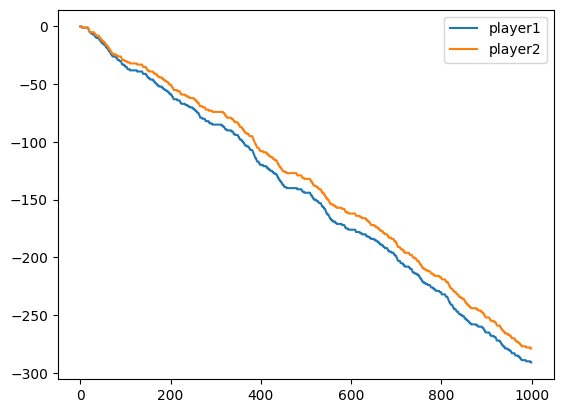


#### Evolution 4


Epoch #1: 1001it [00:01, 868.24it/s, env_step=1000, len=6, n/ep=8, n/st=50, player1/loss=0.381, player2/loss=0.596, rew=-0.25]                          


Epoch #1: test_reward: -0.560000 ± 0.496387, best_reward: -0.320000 ± 0.466476 in #0


Epoch #2: 1001it [00:01, 855.55it/s, env_step=2000, len=5, n/ep=11, n/st=50, player1/loss=0.300, player2/loss=0.548, rew=-0.18]                          


Epoch #2: test_reward: -0.570000 ± 0.495076, best_reward: -0.320000 ± 0.466476 in #0


Epoch #3: 1001it [00:01, 876.14it/s, env_step=3000, len=6, n/ep=9, n/st=50, player1/loss=0.261, player2/loss=0.539, rew=-0.22]                          


Epoch #3: test_reward: -0.410000 ± 0.491833, best_reward: -0.320000 ± 0.466476 in #0


Epoch #4: 1001it [00:01, 895.59it/s, env_step=4000, len=8, n/ep=7, n/st=50, player1/loss=0.292, player2/loss=0.616, rew=-0.43]                          


Epoch #4: test_reward: -0.530000 ± 0.499099, best_reward: -0.320000 ± 0.466476 in #0


Epoch #5: 1001it [00:01, 904.76it/s, env_step=5000, len=9, n/ep=4, n/st=50, player1/loss=0.271, player2/loss=0.588, rew=-0.50]                          


Epoch #5: test_reward: -0.460000 ± 0.498397, best_reward: -0.320000 ± 0.466476 in #0


Epoch #6: 1001it [00:01, 707.65it/s, env_step=6000, len=7, n/ep=8, n/st=50, player1/loss=0.255, player2/loss=0.698, rew=-0.62]                          


Epoch #6: test_reward: -0.420000 ± 0.493559, best_reward: -0.320000 ± 0.466476 in #0


Epoch #7: 1001it [00:01, 745.34it/s, env_step=7000, len=8, n/ep=8, n/st=50, player1/loss=0.242, player2/loss=0.626, rew=-0.50]                          


Epoch #7: test_reward: -0.450000 ± 0.497494, best_reward: -0.320000 ± 0.466476 in #0


Epoch #8: 1001it [00:01, 879.38it/s, env_step=8000, len=8, n/ep=9, n/st=50, player1/loss=0.227, player2/loss=0.683, rew=-0.33]                          


Epoch #8: test_reward: -0.400000 ± 0.489898, best_reward: -0.320000 ± 0.466476 in #0


Epoch #9: 1001it [00:01, 872.02it/s, env_step=9000, len=8, n/ep=5, n/st=50, player1/loss=0.226, player2/loss=0.663, rew=-0.80]                          


Epoch #9: test_reward: -0.480000 ± 0.499600, best_reward: -0.320000 ± 0.466476 in #0


Epoch #10: 1001it [00:01, 840.06it/s, env_step=10000, len=8, n/ep=10, n/st=50, player1/loss=0.231, player2/loss=0.664, rew=-0.50]                          


Epoch #10: test_reward: -0.540000 ± 0.498397, best_reward: -0.320000 ± 0.466476 in #0


Epoch #11: 1001it [00:01, 833.00it/s, env_step=11000, len=9, n/ep=7, n/st=50, player1/loss=0.238, player2/loss=0.670, rew=-0.57]                          


Epoch #11: test_reward: -0.350000 ± 0.476970, best_reward: -0.320000 ± 0.466476 in #0


Epoch #12: 1001it [00:01, 896.27it/s, env_step=12000, len=8, n/ep=8, n/st=50, player1/loss=0.228, player2/loss=0.712, rew=-0.75]                          


Epoch #12: test_reward: -0.330000 ± 0.470213, best_reward: -0.320000 ± 0.466476 in #0


Epoch #13: 1001it [00:01, 743.97it/s, env_step=13000, len=5, n/ep=9, n/st=50, player1/loss=0.230, player2/loss=0.753, rew=-0.67]                          


Epoch #13: test_reward: -0.490000 ± 0.499900, best_reward: -0.320000 ± 0.466476 in #0


Epoch #14: 1001it [00:01, 695.32it/s, env_step=14000, len=8, n/ep=6, n/st=50, player1/loss=0.226, player2/loss=0.652, rew=-0.50]                          


Epoch #14: test_reward: -0.410000 ± 0.491833, best_reward: -0.320000 ± 0.466476 in #0


Epoch #15: 1001it [00:01, 877.65it/s, env_step=15000, len=7, n/ep=8, n/st=50, player1/loss=0.211, player2/loss=0.606, rew=-0.62]                          


Epoch #15: test_reward: -0.510000 ± 0.499900, best_reward: -0.320000 ± 0.466476 in #0


Epoch #16: 1001it [00:01, 907.57it/s, env_step=16000, len=6, n/ep=5, n/st=50, player1/loss=0.198, player2/loss=0.675, rew=-0.40]                          


Epoch #16: test_reward: -0.370000 ± 0.482804, best_reward: -0.320000 ± 0.466476 in #0


Epoch #17: 1001it [00:01, 902.56it/s, env_step=17000, len=8, n/ep=9, n/st=50, player1/loss=0.206, player2/loss=0.684, rew=-0.56]                          


Epoch #17: test_reward: -0.350000 ± 0.476970, best_reward: -0.320000 ± 0.466476 in #0


Epoch #18: 1001it [00:01, 884.45it/s, env_step=18000, len=6, n/ep=6, n/st=50, player1/loss=0.214, player2/loss=0.557, rew=-0.50]                          


Epoch #18: test_reward: -0.490000 ± 0.499900, best_reward: -0.320000 ± 0.466476 in #0


Epoch #19: 1001it [00:01, 883.92it/s, env_step=19000, len=7, n/ep=7, n/st=50, player1/loss=0.236, player2/loss=0.560, rew=-0.43]                          


Epoch #19: test_reward: -0.510000 ± 0.499900, best_reward: -0.320000 ± 0.466476 in #0


Epoch #20: 1001it [00:01, 762.97it/s, env_step=20000, len=9, n/ep=6, n/st=50, player1/loss=0.222, player2/loss=0.569, rew=-0.50]                          


Epoch #20: test_reward: -0.520000 ± 0.499600, best_reward: -0.320000 ± 0.466476 in #0
##########

death rate (in %) of player1: 30.3 +- 6.018
death rate (in %) of player2: 28.3 +- 4.522


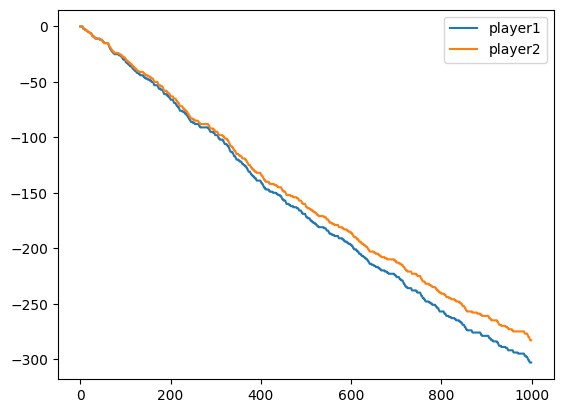


#### Evolution 5


Epoch #1: 1001it [00:01, 870.69it/s, env_step=1000, len=7, n/ep=7, n/st=50, player1/loss=0.335, player2/loss=0.495, rew=-0.86]                          


Epoch #1: test_reward: -0.640000 ± 0.480000, best_reward: -0.330000 ± 0.470213 in #0


Epoch #2: 1001it [00:01, 881.91it/s, env_step=2000, len=8, n/ep=5, n/st=50, player1/loss=0.258, player2/loss=0.428, rew=-0.40]                          


Epoch #2: test_reward: -0.470000 ± 0.499099, best_reward: -0.330000 ± 0.470213 in #0


Epoch #3: 1001it [00:01, 881.31it/s, env_step=3000, len=8, n/ep=9, n/st=50, player1/loss=0.235, player2/loss=0.464, rew=-0.44]                          


Epoch #3: test_reward: -0.380000 ± 0.485386, best_reward: -0.330000 ± 0.470213 in #0


Epoch #4: 1001it [00:01, 652.99it/s, env_step=4000, len=5, n/ep=10, n/st=50, player1/loss=0.217, player2/loss=0.481, rew=-0.10]                          


Epoch #4: test_reward: -0.400000 ± 0.489898, best_reward: -0.330000 ± 0.470213 in #0


Epoch #5: 1001it [00:01, 877.57it/s, env_step=5000, len=6, n/ep=8, n/st=50, player1/loss=0.193, player2/loss=0.441, rew=-0.25]                          


Epoch #5: test_reward: -0.460000 ± 0.498397, best_reward: -0.330000 ± 0.470213 in #0


Epoch #6: 1001it [00:01, 862.67it/s, env_step=6000, len=8, n/ep=6, n/st=50, player1/loss=0.200, player2/loss=0.420, rew=-0.50]                          


Epoch #6: test_reward: -0.430000 ± 0.495076, best_reward: -0.330000 ± 0.470213 in #0


Epoch #7: 1001it [00:01, 846.39it/s, env_step=7000, len=5, n/ep=4, n/st=50, player1/loss=0.190, player2/loss=0.473, rew=-0.25]                          


Epoch #7: test_reward: -0.450000 ± 0.497494, best_reward: -0.330000 ± 0.470213 in #0


Epoch #8: 1001it [00:01, 861.79it/s, env_step=8000, len=6, n/ep=7, n/st=50, player1/loss=0.211, player2/loss=0.477, rew=-0.14]                          


Epoch #8: test_reward: -0.440000 ± 0.496387, best_reward: -0.330000 ± 0.470213 in #0


Epoch #9: 1001it [00:01, 865.67it/s, env_step=9000, len=5, n/ep=6, n/st=50, player1/loss=0.212, player2/loss=0.491, rew=-0.50]                          


Epoch #9: test_reward: -0.420000 ± 0.493559, best_reward: -0.330000 ± 0.470213 in #0


Epoch #10: 1001it [00:01, 842.04it/s, env_step=10000, len=6, n/ep=7, n/st=50, player1/loss=0.216, player2/loss=0.472, rew=-0.43]                          


Epoch #10: test_reward: -0.370000 ± 0.482804, best_reward: -0.330000 ± 0.470213 in #0


Epoch #11: 1001it [00:01, 684.09it/s, env_step=11000, len=7, n/ep=8, n/st=50, player1/loss=0.195, player2/loss=0.452, rew=-0.12]                          


Epoch #11: test_reward: -0.430000 ± 0.495076, best_reward: -0.330000 ± 0.470213 in #0


Epoch #12: 1001it [00:01, 856.16it/s, env_step=12000, len=7, n/ep=9, n/st=50, player1/loss=0.192, player2/loss=0.481, rew=-0.22]                          


Epoch #12: test_reward: -0.460000 ± 0.498397, best_reward: -0.330000 ± 0.470213 in #0


Epoch #13: 1001it [00:01, 874.86it/s, env_step=13000, len=6, n/ep=7, n/st=50, player1/loss=0.198, player2/loss=0.467, rew=0.00]                          


Epoch #13: test_reward: -0.290000 ± 0.453762, best_reward: -0.290000 ± 0.453762 in #13


Epoch #14: 1001it [00:01, 888.84it/s, env_step=14000, len=6, n/ep=9, n/st=50, player1/loss=0.201, player2/loss=0.507, rew=-0.44]                          


Epoch #14: test_reward: -0.280000 ± 0.448999, best_reward: -0.280000 ± 0.448999 in #14


Epoch #15: 1001it [00:01, 862.52it/s, env_step=15000, len=8, n/ep=7, n/st=50, player1/loss=0.205, player2/loss=0.493, rew=-0.29]                          


Epoch #15: test_reward: -0.540000 ± 0.498397, best_reward: -0.280000 ± 0.448999 in #14


Epoch #16: 1001it [00:01, 884.30it/s, env_step=16000, len=7, n/ep=5, n/st=50, player1/loss=0.197, player2/loss=0.499, rew=-0.40]                          


Epoch #16: test_reward: -0.550000 ± 0.497494, best_reward: -0.280000 ± 0.448999 in #14


Epoch #17: 1001it [00:01, 889.01it/s, env_step=17000, len=6, n/ep=7, n/st=50, player1/loss=0.194, player2/loss=0.483, rew=-0.43]                          


Epoch #17: test_reward: -0.380000 ± 0.485386, best_reward: -0.280000 ± 0.448999 in #14


Epoch #18: 1001it [00:01, 716.47it/s, env_step=18000, len=7, n/ep=9, n/st=50, player1/loss=0.197, player2/loss=0.514, rew=-0.33]                          


Epoch #18: test_reward: -0.330000 ± 0.470213, best_reward: -0.280000 ± 0.448999 in #14


Epoch #19: 1001it [00:01, 866.05it/s, env_step=19000, len=10, n/ep=7, n/st=50, player1/loss=0.185, player2/loss=0.458, rew=-0.43]                          


Epoch #19: test_reward: -0.540000 ± 0.498397, best_reward: -0.280000 ± 0.448999 in #14


Epoch #20: 1001it [00:01, 886.10it/s, env_step=20000, len=6, n/ep=11, n/st=50, player1/loss=0.177, player2/loss=0.569, rew=-0.45]                          


Epoch #20: test_reward: -0.440000 ± 0.496387, best_reward: -0.280000 ± 0.448999 in #14
##########

death rate (in %) of player1: 30.8 +- 6.773
death rate (in %) of player2: 29.4 +- 5.043


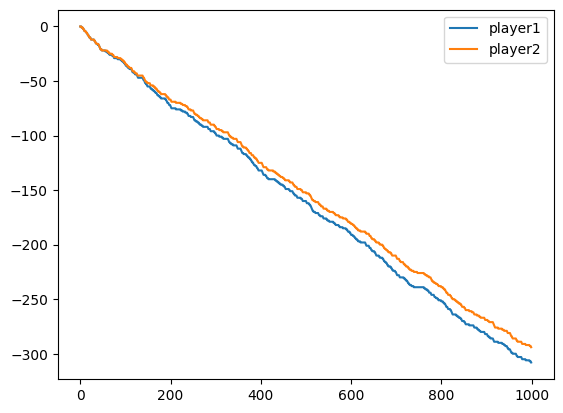


#### Evolution 6


Epoch #1: 1001it [00:01, 728.83it/s, env_step=1000, len=9, n/ep=6, n/st=50, player1/loss=0.368, player2/loss=0.448, rew=-0.50]                          


Epoch #1: test_reward: -0.450000 ± 0.497494, best_reward: -0.350000 ± 0.476970 in #0


Epoch #2: 1001it [00:01, 701.70it/s, env_step=2000, len=8, n/ep=4, n/st=50, player1/loss=0.304, player2/loss=0.454, rew=-0.50]                          


Epoch #2: test_reward: -0.450000 ± 0.497494, best_reward: -0.350000 ± 0.476970 in #0


Epoch #3: 1001it [00:01, 867.18it/s, env_step=3000, len=6, n/ep=8, n/st=50, player1/loss=0.240, player2/loss=0.465, rew=-0.25]                          


Epoch #3: test_reward: -0.580000 ± 0.493559, best_reward: -0.350000 ± 0.476970 in #0


Epoch #4: 1001it [00:01, 874.87it/s, env_step=4000, len=8, n/ep=7, n/st=50, player1/loss=0.225, player2/loss=0.496, rew=-0.57]                          


Epoch #4: test_reward: -0.400000 ± 0.489898, best_reward: -0.350000 ± 0.476970 in #0


Epoch #5: 1001it [00:01, 886.90it/s, env_step=5000, len=9, n/ep=12, n/st=50, player1/loss=0.247, player2/loss=0.456, rew=-0.42]                          


Epoch #5: test_reward: -0.540000 ± 0.498397, best_reward: -0.350000 ± 0.476970 in #0


Epoch #6: 1001it [00:01, 836.96it/s, env_step=6000, len=5, n/ep=5, n/st=50, player1/loss=0.196, player2/loss=0.530, rew=-0.60]                          


Epoch #6: test_reward: -0.390000 ± 0.487750, best_reward: -0.350000 ± 0.476970 in #0


Epoch #7: 1001it [00:01, 844.46it/s, env_step=7000, len=5, n/ep=6, n/st=50, player1/loss=0.182, player2/loss=0.530, rew=-0.33]                          


Epoch #7: test_reward: -0.490000 ± 0.499900, best_reward: -0.350000 ± 0.476970 in #0


Epoch #8: 1001it [00:01, 760.18it/s, env_step=8000, len=7, n/ep=8, n/st=50, player1/loss=0.192, player2/loss=0.480, rew=-0.62]                          


Epoch #8: test_reward: -0.620000 ± 0.485386, best_reward: -0.350000 ± 0.476970 in #0


Epoch #9: 1001it [00:01, 661.66it/s, env_step=9000, len=8, n/ep=9, n/st=50, player1/loss=0.233, player2/loss=0.510, rew=-0.78]                          


Epoch #9: test_reward: -0.470000 ± 0.499099, best_reward: -0.350000 ± 0.476970 in #0


Epoch #10: 1001it [00:01, 829.11it/s, env_step=10000, len=4, n/ep=8, n/st=50, player1/loss=0.219, player2/loss=0.471, rew=-0.25]                          


Epoch #10: test_reward: -0.540000 ± 0.498397, best_reward: -0.350000 ± 0.476970 in #0


Epoch #11: 1001it [00:01, 844.40it/s, env_step=11000, len=7, n/ep=9, n/st=50, player1/loss=0.187, player2/loss=0.498, rew=-0.67]                          


Epoch #11: test_reward: -0.540000 ± 0.498397, best_reward: -0.350000 ± 0.476970 in #0


Epoch #12: 1001it [00:01, 872.05it/s, env_step=12000, len=8, n/ep=8, n/st=50, player1/loss=0.202, player2/loss=0.473, rew=-0.50]                          


Epoch #12: test_reward: -0.460000 ± 0.498397, best_reward: -0.350000 ± 0.476970 in #0


Epoch #13: 1001it [00:01, 872.39it/s, env_step=13000, len=7, n/ep=8, n/st=50, player1/loss=0.209, player2/loss=0.530, rew=-0.62]                          


Epoch #13: test_reward: -0.490000 ± 0.499900, best_reward: -0.350000 ± 0.476970 in #0


Epoch #14: 1001it [00:01, 836.23it/s, env_step=14000, len=7, n/ep=8, n/st=50, player1/loss=0.215, player2/loss=0.529, rew=-0.50]                          


Epoch #14: test_reward: -0.530000 ± 0.499099, best_reward: -0.350000 ± 0.476970 in #0


Epoch #15: 1001it [00:01, 785.90it/s, env_step=15000, len=6, n/ep=5, n/st=50, player1/loss=0.195, player2/loss=0.527, rew=-0.20]                          


Epoch #15: test_reward: -0.280000 ± 0.448999, best_reward: -0.280000 ± 0.448999 in #15


Epoch #16: 1001it [00:01, 647.79it/s, env_step=16000, len=7, n/ep=4, n/st=50, player1/loss=0.190, player2/loss=0.510, rew=-0.25]                          


Epoch #16: test_reward: -0.440000 ± 0.496387, best_reward: -0.280000 ± 0.448999 in #15


Epoch #17: 1001it [00:01, 839.88it/s, env_step=17000, len=7, n/ep=10, n/st=50, player1/loss=0.175, player2/loss=0.496, rew=-0.50]                          


Epoch #17: test_reward: -0.420000 ± 0.493559, best_reward: -0.280000 ± 0.448999 in #15


Epoch #18: 1001it [00:01, 885.56it/s, env_step=18000, len=6, n/ep=8, n/st=50, player1/loss=0.179, player2/loss=0.525, rew=-0.50]                          


Epoch #18: test_reward: -0.360000 ± 0.480000, best_reward: -0.280000 ± 0.448999 in #15


Epoch #19: 1001it [00:01, 866.51it/s, env_step=19000, len=6, n/ep=7, n/st=50, player1/loss=0.193, player2/loss=0.619, rew=-0.29]                          


Epoch #19: test_reward: -0.490000 ± 0.499900, best_reward: -0.280000 ± 0.448999 in #15


Epoch #20: 1001it [00:01, 867.26it/s, env_step=20000, len=7, n/ep=5, n/st=50, player1/loss=0.208, player2/loss=0.571, rew=-0.20]                          


Epoch #20: test_reward: -0.420000 ± 0.493559, best_reward: -0.280000 ± 0.448999 in #15
##########

death rate (in %) of player1: 29.4 +- 5.312
death rate (in %) of player2: 27.8 +- 5.617


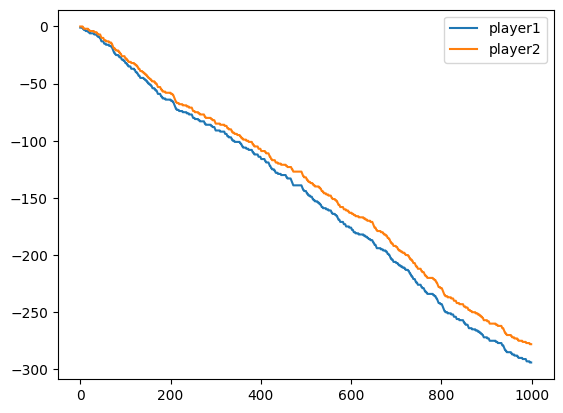


#### Evolution 7


Epoch #1: 1001it [00:01, 846.25it/s, env_step=1000, len=6, n/ep=9, n/st=50, player1/loss=0.473, player2/loss=0.532, rew=-0.44]                          


Epoch #1: test_reward: -0.620000 ± 0.485386, best_reward: -0.230000 ± 0.420833 in #0


Epoch #2: 1001it [00:01, 860.07it/s, env_step=2000, len=6, n/ep=5, n/st=50, player1/loss=0.294, player2/loss=0.564, rew=-0.20]                          


Epoch #2: test_reward: -0.340000 ± 0.473709, best_reward: -0.230000 ± 0.420833 in #0


Epoch #3: 1001it [00:01, 844.05it/s, env_step=3000, len=6, n/ep=8, n/st=50, player1/loss=0.258, player2/loss=0.520, rew=-0.25]                          


Epoch #3: test_reward: -0.490000 ± 0.499900, best_reward: -0.230000 ± 0.420833 in #0


Epoch #4: 1001it [00:01, 861.05it/s, env_step=4000, len=6, n/ep=8, n/st=50, player1/loss=0.263, player2/loss=0.534, rew=-0.25]                          


Epoch #4: test_reward: -0.470000 ± 0.499099, best_reward: -0.230000 ± 0.420833 in #0


Epoch #5: 1001it [00:01, 852.29it/s, env_step=5000, len=10, n/ep=4, n/st=50, player1/loss=0.243, player2/loss=0.499, rew=-0.75]                          


Epoch #5: test_reward: -0.530000 ± 0.499099, best_reward: -0.230000 ± 0.420833 in #0


Epoch #6: 1001it [00:01, 699.18it/s, env_step=6000, len=7, n/ep=7, n/st=50, player1/loss=0.238, player2/loss=0.513, rew=-0.29]                          


Epoch #6: test_reward: -0.680000 ± 0.466476, best_reward: -0.230000 ± 0.420833 in #0


Epoch #7: 1001it [00:01, 852.96it/s, env_step=7000, len=8, n/ep=6, n/st=50, player1/loss=0.204, player2/loss=0.510, rew=-0.83]                          


Epoch #7: test_reward: -0.530000 ± 0.499099, best_reward: -0.230000 ± 0.420833 in #0


Epoch #8: 1001it [00:01, 858.23it/s, env_step=8000, len=8, n/ep=6, n/st=50, player1/loss=0.216, player2/loss=0.561, rew=-0.83]                          


Epoch #8: test_reward: -0.440000 ± 0.496387, best_reward: -0.230000 ± 0.420833 in #0


Epoch #9: 1001it [00:01, 858.53it/s, env_step=9000, len=10, n/ep=8, n/st=50, player1/loss=0.216, player2/loss=0.567, rew=-0.62]                          


Epoch #9: test_reward: -0.430000 ± 0.495076, best_reward: -0.230000 ± 0.420833 in #0


Epoch #10: 1001it [00:01, 824.86it/s, env_step=10000, len=5, n/ep=10, n/st=50, player1/loss=0.236, player2/loss=0.584, rew=-0.40]                          


Epoch #10: test_reward: -0.560000 ± 0.496387, best_reward: -0.230000 ± 0.420833 in #0


Epoch #11: 1001it [00:01, 818.28it/s, env_step=11000, len=7, n/ep=11, n/st=50, player1/loss=0.213, player2/loss=0.596, rew=-0.55]                          


Epoch #11: test_reward: -0.590000 ± 0.491833, best_reward: -0.230000 ± 0.420833 in #0


Epoch #12: 1001it [00:01, 828.03it/s, env_step=12000, len=10, n/ep=3, n/st=50, player1/loss=0.223, player2/loss=0.587, rew=-1.00]                          


Epoch #12: test_reward: -0.500000 ± 0.500000, best_reward: -0.230000 ± 0.420833 in #0


Epoch #13: 1001it [00:01, 662.01it/s, env_step=13000, len=7, n/ep=9, n/st=50, player1/loss=0.226, player2/loss=0.621, rew=-0.22]                          


Epoch #13: test_reward: -0.450000 ± 0.497494, best_reward: -0.230000 ± 0.420833 in #0


Epoch #14: 1001it [00:01, 853.94it/s, env_step=14000, len=7, n/ep=7, n/st=50, player1/loss=0.217, player2/loss=0.631, rew=-0.57]                          


Epoch #14: test_reward: -0.410000 ± 0.491833, best_reward: -0.230000 ± 0.420833 in #0


Epoch #15: 1001it [00:01, 845.91it/s, env_step=15000, len=7, n/ep=12, n/st=50, player1/loss=0.234, player2/loss=0.561, rew=-0.58]                          


Epoch #15: test_reward: -0.540000 ± 0.498397, best_reward: -0.230000 ± 0.420833 in #0


Epoch #16: 1001it [00:01, 837.02it/s, env_step=16000, len=7, n/ep=8, n/st=50, player1/loss=0.255, player2/loss=0.548, rew=-0.62]                          


Epoch #16: test_reward: -0.610000 ± 0.487750, best_reward: -0.230000 ± 0.420833 in #0


Epoch #17: 1001it [00:01, 849.16it/s, env_step=17000, len=7, n/ep=8, n/st=50, player1/loss=0.224, player2/loss=0.584, rew=-0.75]                          


Epoch #17: test_reward: -0.590000 ± 0.491833, best_reward: -0.230000 ± 0.420833 in #0


Epoch #18: 1001it [00:01, 842.89it/s, env_step=18000, len=10, n/ep=5, n/st=50, player1/loss=0.244, player2/loss=0.600, rew=-0.80]                          


Epoch #18: test_reward: -0.530000 ± 0.499099, best_reward: -0.230000 ± 0.420833 in #0


Epoch #19: 1001it [00:01, 834.53it/s, env_step=19000, len=7, n/ep=8, n/st=50, player1/loss=0.218, player2/loss=0.660, rew=-0.12]                          


Epoch #19: test_reward: -0.600000 ± 0.489898, best_reward: -0.230000 ± 0.420833 in #0


Epoch #20: 1001it [00:01, 630.54it/s, env_step=20000, len=7, n/ep=8, n/st=50, player1/loss=0.225, player2/loss=0.631, rew=-0.62]                          


Epoch #20: test_reward: -0.620000 ± 0.485386, best_reward: -0.230000 ± 0.420833 in #0
##########

death rate (in %) of player1: 29.2 +- 9.141
death rate (in %) of player2: 28.2 +- 6.356


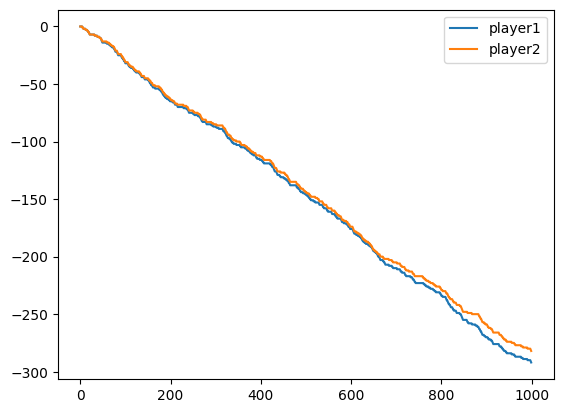


#### Evolution 8


Epoch #1: 1001it [00:01, 807.07it/s, env_step=1000, len=9, n/ep=8, n/st=50, player1/loss=0.514, player2/loss=0.557, rew=-0.62]                          


Epoch #1: test_reward: -0.580000 ± 0.493559, best_reward: -0.190000 ± 0.392301 in #0


Epoch #2: 1001it [00:01, 849.29it/s, env_step=2000, len=10, n/ep=9, n/st=50, player1/loss=0.355, player2/loss=0.540, rew=-0.56]                          


Epoch #2: test_reward: -0.510000 ± 0.499900, best_reward: -0.190000 ± 0.392301 in #0


Epoch #3: 1001it [00:01, 665.15it/s, env_step=3000, len=6, n/ep=8, n/st=50, player1/loss=0.284, player2/loss=0.539, rew=-0.38]                          


Epoch #3: test_reward: -0.530000 ± 0.499099, best_reward: -0.190000 ± 0.392301 in #0


Epoch #4: 1001it [00:01, 819.36it/s, env_step=4000, len=10, n/ep=4, n/st=50, player1/loss=0.267, player2/loss=0.537, rew=-0.50]                          


Epoch #4: test_reward: -0.580000 ± 0.493559, best_reward: -0.190000 ± 0.392301 in #0


Epoch #5: 1001it [00:01, 850.17it/s, env_step=5000, len=7, n/ep=8, n/st=50, player1/loss=0.274, player2/loss=0.566, rew=-0.75]                          


Epoch #5: test_reward: -0.460000 ± 0.498397, best_reward: -0.190000 ± 0.392301 in #0


Epoch #6: 1001it [00:01, 856.20it/s, env_step=6000, len=8, n/ep=8, n/st=50, player1/loss=0.252, player2/loss=0.532, rew=-0.38]                          


Epoch #6: test_reward: -0.470000 ± 0.499099, best_reward: -0.190000 ± 0.392301 in #0


Epoch #7: 1001it [00:01, 846.92it/s, env_step=7000, len=7, n/ep=12, n/st=50, player1/loss=0.261, player2/loss=0.522, rew=-0.42]                          


Epoch #7: test_reward: -0.520000 ± 0.499600, best_reward: -0.190000 ± 0.392301 in #0


Epoch #8: 1001it [00:01, 834.20it/s, env_step=8000, len=9, n/ep=9, n/st=50, player1/loss=0.247, player2/loss=0.491, rew=-0.78]                          


Epoch #8: test_reward: -0.520000 ± 0.499600, best_reward: -0.190000 ± 0.392301 in #0


Epoch #9: 1001it [00:01, 835.03it/s, env_step=9000, len=8, n/ep=7, n/st=50, player1/loss=0.233, player2/loss=0.554, rew=-0.86]                          


Epoch #9: test_reward: -0.560000 ± 0.496387, best_reward: -0.190000 ± 0.392301 in #0


Epoch #10: 1001it [00:01, 651.07it/s, env_step=10000, len=9, n/ep=8, n/st=50, player1/loss=0.223, player2/loss=0.530, rew=-0.75]                          


Epoch #10: test_reward: -0.480000 ± 0.499600, best_reward: -0.190000 ± 0.392301 in #0


Epoch #11: 1001it [00:01, 863.33it/s, env_step=11000, len=7, n/ep=4, n/st=50, player1/loss=0.229, player2/loss=0.586, rew=0.00]                          


Epoch #11: test_reward: -0.460000 ± 0.498397, best_reward: -0.190000 ± 0.392301 in #0


Epoch #12: 1001it [00:01, 876.63it/s, env_step=12000, len=8, n/ep=5, n/st=50, player1/loss=0.258, player2/loss=0.563, rew=-0.80]                          


Epoch #12: test_reward: -0.500000 ± 0.500000, best_reward: -0.190000 ± 0.392301 in #0


Epoch #13: 1001it [00:01, 838.92it/s, env_step=13000, len=6, n/ep=8, n/st=50, player1/loss=0.234, player2/loss=0.675, rew=-0.25]                          


Epoch #13: test_reward: -0.500000 ± 0.500000, best_reward: -0.190000 ± 0.392301 in #0


Epoch #14: 1001it [00:01, 834.55it/s, env_step=14000, len=7, n/ep=8, n/st=50, player1/loss=0.230, player2/loss=0.614, rew=-0.38]                          


Epoch #14: test_reward: -0.600000 ± 0.489898, best_reward: -0.190000 ± 0.392301 in #0


Epoch #15: 1001it [00:01, 836.67it/s, env_step=15000, len=6, n/ep=4, n/st=50, player1/loss=0.226, player2/loss=0.629, rew=-0.25]                          


Epoch #15: test_reward: -0.370000 ± 0.482804, best_reward: -0.190000 ± 0.392301 in #0


Epoch #16: 1001it [00:01, 839.58it/s, env_step=16000, len=7, n/ep=8, n/st=50, player1/loss=0.249, player2/loss=0.646, rew=-0.50]                          


Epoch #16: test_reward: -0.400000 ± 0.489898, best_reward: -0.190000 ± 0.392301 in #0


Epoch #17: 1001it [00:01, 676.40it/s, env_step=17000, len=9, n/ep=7, n/st=50, player1/loss=0.249, player2/loss=0.619, rew=-0.57]                          


Epoch #17: test_reward: -0.550000 ± 0.497494, best_reward: -0.190000 ± 0.392301 in #0


Epoch #18: 1001it [00:01, 831.60it/s, env_step=18000, len=7, n/ep=10, n/st=50, player1/loss=0.257, player2/loss=0.688, rew=-0.60]                          


Epoch #18: test_reward: -0.540000 ± 0.498397, best_reward: -0.190000 ± 0.392301 in #0


Epoch #19: 1001it [00:01, 850.26it/s, env_step=19000, len=9, n/ep=6, n/st=50, player1/loss=0.244, player2/loss=0.687, rew=-0.83]                          


Epoch #19: test_reward: -0.440000 ± 0.496387, best_reward: -0.190000 ± 0.392301 in #0


Epoch #20: 1001it [00:01, 834.84it/s, env_step=20000, len=5, n/ep=14, n/st=50, player1/loss=0.231, player2/loss=0.695, rew=-0.43]                          


Epoch #20: test_reward: -0.540000 ± 0.498397, best_reward: -0.190000 ± 0.392301 in #0
##########

death rate (in %) of player1: 28.0 +- 8.524
death rate (in %) of player2: 26.4 +- 5.692


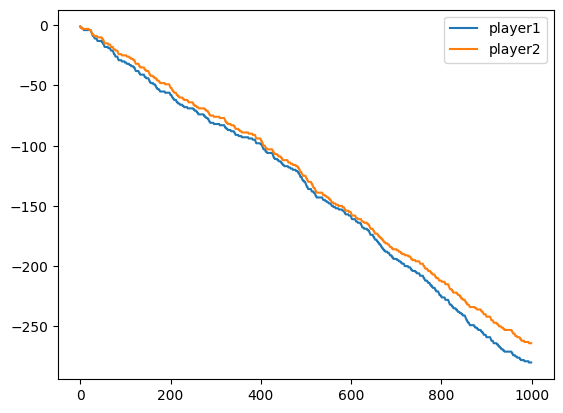


#### Evolution 9


Epoch #1: 1001it [00:01, 745.11it/s, env_step=1000, len=9, n/ep=8, n/st=50, player1/loss=0.523, player2/loss=0.564, rew=-0.62]                          


Epoch #1: test_reward: -0.540000 ± 0.498397, best_reward: -0.290000 ± 0.453762 in #0


Epoch #2: 1001it [00:01, 830.78it/s, env_step=2000, len=8, n/ep=8, n/st=50, player1/loss=0.388, player2/loss=0.591, rew=-0.50]                          


Epoch #2: test_reward: -0.420000 ± 0.493559, best_reward: -0.290000 ± 0.453762 in #0


Epoch #3: 1001it [00:01, 837.02it/s, env_step=3000, len=8, n/ep=7, n/st=50, player1/loss=0.362, player2/loss=0.598, rew=-0.43]                          


Epoch #3: test_reward: -0.510000 ± 0.499900, best_reward: -0.290000 ± 0.453762 in #0


Epoch #4: 1001it [00:01, 868.87it/s, env_step=4000, len=7, n/ep=9, n/st=50, player1/loss=0.273, player2/loss=0.521, rew=-0.56]                          


Epoch #4: test_reward: -0.500000 ± 0.500000, best_reward: -0.290000 ± 0.453762 in #0


Epoch #5: 1001it [00:01, 839.56it/s, env_step=5000, len=9, n/ep=6, n/st=50, player1/loss=0.283, player2/loss=0.585, rew=-0.50]                          


Epoch #5: test_reward: -0.520000 ± 0.499600, best_reward: -0.290000 ± 0.453762 in #0


Epoch #6: 1001it [00:01, 874.32it/s, env_step=6000, len=8, n/ep=9, n/st=50, player1/loss=0.257, player2/loss=0.649, rew=-0.78]                          


Epoch #6: test_reward: -0.510000 ± 0.499900, best_reward: -0.290000 ± 0.453762 in #0


Epoch #7: 1001it [00:01, 659.94it/s, env_step=7000, len=11, n/ep=7, n/st=50, player1/loss=0.248, player2/loss=0.621, rew=-0.71]                          


Epoch #7: test_reward: -0.550000 ± 0.497494, best_reward: -0.290000 ± 0.453762 in #0


Epoch #8: 1001it [00:01, 728.63it/s, env_step=8000, len=6, n/ep=10, n/st=50, player1/loss=0.241, player2/loss=0.705, rew=-0.50]                          


Epoch #8: test_reward: -0.570000 ± 0.495076, best_reward: -0.290000 ± 0.453762 in #0


Epoch #9: 1001it [00:01, 854.97it/s, env_step=9000, len=8, n/ep=8, n/st=50, player1/loss=0.245, player2/loss=0.786, rew=-0.62]                          


Epoch #9: test_reward: -0.620000 ± 0.485386, best_reward: -0.290000 ± 0.453762 in #0


Epoch #10: 1001it [00:01, 818.34it/s, env_step=10000, len=7, n/ep=12, n/st=50, player1/loss=0.237, player2/loss=0.633, rew=-0.42]                          


Epoch #10: test_reward: -0.620000 ± 0.485386, best_reward: -0.290000 ± 0.453762 in #0


Epoch #11: 1001it [00:01, 845.14it/s, env_step=11000, len=8, n/ep=7, n/st=50, player1/loss=0.214, player2/loss=0.666, rew=-0.43]                          


Epoch #11: test_reward: -0.510000 ± 0.499900, best_reward: -0.290000 ± 0.453762 in #0


Epoch #12: 1001it [00:01, 866.69it/s, env_step=12000, len=10, n/ep=8, n/st=50, player1/loss=0.262, player2/loss=0.704, rew=-0.38]                          


Epoch #12: test_reward: -0.590000 ± 0.491833, best_reward: -0.290000 ± 0.453762 in #0


Epoch #13: 1001it [00:01, 831.02it/s, env_step=13000, len=8, n/ep=8, n/st=50, player1/loss=0.265, player2/loss=0.748, rew=-0.50]                          


Epoch #13: test_reward: -0.580000 ± 0.493559, best_reward: -0.290000 ± 0.453762 in #0


Epoch #14: 1001it [00:01, 695.77it/s, env_step=14000, len=9, n/ep=5, n/st=50, player1/loss=0.249, player2/loss=0.676, rew=-0.80]                          


Epoch #14: test_reward: -0.470000 ± 0.499099, best_reward: -0.290000 ± 0.453762 in #0


Epoch #15: 1001it [00:01, 795.27it/s, env_step=15000, len=8, n/ep=9, n/st=50, player1/loss=0.255, player2/loss=0.692, rew=-0.56]                          


Epoch #15: test_reward: -0.440000 ± 0.496387, best_reward: -0.290000 ± 0.453762 in #0


Epoch #16: 1001it [00:01, 830.77it/s, env_step=16000, len=7, n/ep=4, n/st=50, player1/loss=0.258, player2/loss=0.704, rew=-0.50]                          


Epoch #16: test_reward: -0.520000 ± 0.499600, best_reward: -0.290000 ± 0.453762 in #0


Epoch #17: 1001it [00:01, 839.41it/s, env_step=17000, len=9, n/ep=6, n/st=50, player1/loss=0.241, player2/loss=0.663, rew=-0.50]                          


Epoch #17: test_reward: -0.570000 ± 0.495076, best_reward: -0.290000 ± 0.453762 in #0


Epoch #18: 1001it [00:01, 852.67it/s, env_step=18000, len=6, n/ep=9, n/st=50, player1/loss=0.242, player2/loss=0.731, rew=-0.33]                          


Epoch #18: test_reward: -0.690000 ± 0.462493, best_reward: -0.290000 ± 0.453762 in #0


Epoch #19: 1001it [00:01, 824.64it/s, env_step=19000, len=8, n/ep=8, n/st=50, player1/loss=0.228, player2/loss=0.748, rew=-0.75]                          


Epoch #19: test_reward: -0.570000 ± 0.495076, best_reward: -0.290000 ± 0.453762 in #0


Epoch #20: 1001it [00:01, 852.12it/s, env_step=20000, len=9, n/ep=6, n/st=50, player1/loss=0.265, player2/loss=0.743, rew=-0.50]                          


Epoch #20: test_reward: -0.560000 ± 0.496387, best_reward: -0.290000 ± 0.453762 in #0
##########

death rate (in %) of player1: 28.3 +- 5.477
death rate (in %) of player2: 26.1 +- 6.967


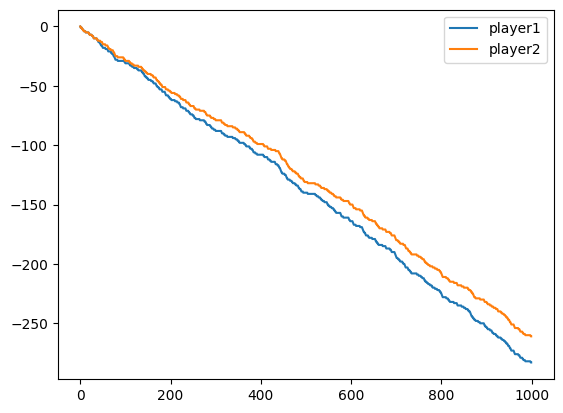


#### Evolution 10


Epoch #1: 1001it [00:01, 830.87it/s, env_step=1000, len=8, n/ep=7, n/st=50, player1/loss=0.540, player2/loss=0.647, rew=-0.57]                          


Epoch #1: test_reward: -0.460000 ± 0.498397, best_reward: -0.210000 ± 0.407308 in #0


Epoch #2: 1001it [00:01, 833.41it/s, env_step=2000, len=7, n/ep=7, n/st=50, player1/loss=0.389, player2/loss=0.680, rew=-0.57]                          


Epoch #2: test_reward: -0.670000 ± 0.470213, best_reward: -0.210000 ± 0.407308 in #0


Epoch #3: 1001it [00:01, 800.65it/s, env_step=3000, len=8, n/ep=9, n/st=50, player1/loss=0.331, player2/loss=0.571, rew=-0.33]                          


Epoch #3: test_reward: -0.480000 ± 0.499600, best_reward: -0.210000 ± 0.407308 in #0


Epoch #4: 1001it [00:01, 656.40it/s, env_step=4000, len=7, n/ep=10, n/st=50, player1/loss=0.286, player2/loss=0.632, rew=-0.60]                          


Epoch #4: test_reward: -0.480000 ± 0.499600, best_reward: -0.210000 ± 0.407308 in #0


Epoch #5: 1001it [00:01, 714.07it/s, env_step=5000, len=8, n/ep=10, n/st=50, player1/loss=0.289, player2/loss=0.565, rew=-0.50]                          


Epoch #5: test_reward: -0.510000 ± 0.499900, best_reward: -0.210000 ± 0.407308 in #0


Epoch #6: 1001it [00:01, 818.85it/s, env_step=6000, len=6, n/ep=9, n/st=50, player1/loss=0.250, player2/loss=0.547, rew=-0.56]                          


Epoch #6: test_reward: -0.590000 ± 0.491833, best_reward: -0.210000 ± 0.407308 in #0


Epoch #7: 1001it [00:01, 845.72it/s, env_step=7000, len=6, n/ep=5, n/st=50, player1/loss=0.221, player2/loss=0.497, rew=-0.20]                          


Epoch #7: test_reward: -0.550000 ± 0.497494, best_reward: -0.210000 ± 0.407308 in #0


Epoch #8: 1001it [00:01, 847.72it/s, env_step=8000, len=9, n/ep=9, n/st=50, player1/loss=0.242, player2/loss=0.567, rew=-0.67]                          


Epoch #8: test_reward: -0.520000 ± 0.499600, best_reward: -0.210000 ± 0.407308 in #0


Epoch #9: 1001it [00:01, 837.60it/s, env_step=9000, len=7, n/ep=7, n/st=50, player1/loss=0.231, player2/loss=0.578, rew=-0.57]                          


Epoch #9: test_reward: -0.510000 ± 0.499900, best_reward: -0.210000 ± 0.407308 in #0


Epoch #10: 1001it [00:01, 838.09it/s, env_step=10000, len=8, n/ep=9, n/st=50, player1/loss=0.239, player2/loss=0.556, rew=-0.56]                          


Epoch #10: test_reward: -0.570000 ± 0.495076, best_reward: -0.210000 ± 0.407308 in #0


Epoch #11: 1001it [00:01, 651.05it/s, env_step=11000, len=7, n/ep=5, n/st=50, player1/loss=0.224, player2/loss=0.540, rew=-0.80]                          


Epoch #11: test_reward: -0.600000 ± 0.489898, best_reward: -0.210000 ± 0.407308 in #0


Epoch #12: 1001it [00:01, 712.51it/s, env_step=12000, len=9, n/ep=6, n/st=50, player1/loss=0.203, player2/loss=0.587, rew=-0.50]                          


Epoch #12: test_reward: -0.590000 ± 0.491833, best_reward: -0.210000 ± 0.407308 in #0


Epoch #13: 1001it [00:01, 839.20it/s, env_step=13000, len=7, n/ep=8, n/st=50, player1/loss=0.229, player2/loss=0.621, rew=-0.38]                          


Epoch #13: test_reward: -0.610000 ± 0.487750, best_reward: -0.210000 ± 0.407308 in #0


Epoch #14: 1001it [00:01, 839.29it/s, env_step=14000, len=8, n/ep=7, n/st=50, player1/loss=0.236, player2/loss=0.590, rew=-0.86]                          


Epoch #14: test_reward: -0.630000 ± 0.482804, best_reward: -0.210000 ± 0.407308 in #0


Epoch #15: 1001it [00:01, 861.90it/s, env_step=15000, len=6, n/ep=6, n/st=50, player1/loss=0.231, player2/loss=0.547, rew=-0.50]                          


Epoch #15: test_reward: -0.510000 ± 0.499900, best_reward: -0.210000 ± 0.407308 in #0


Epoch #16: 1001it [00:01, 848.21it/s, env_step=16000, len=9, n/ep=9, n/st=50, player1/loss=0.232, player2/loss=0.583, rew=-0.89]                          


Epoch #16: test_reward: -0.460000 ± 0.498397, best_reward: -0.210000 ± 0.407308 in #0


Epoch #17: 1001it [00:01, 840.45it/s, env_step=17000, len=6, n/ep=6, n/st=50, player1/loss=0.236, player2/loss=0.558, rew=-0.50]                          


Epoch #17: test_reward: -0.530000 ± 0.499099, best_reward: -0.210000 ± 0.407308 in #0


Epoch #18: 1001it [00:01, 686.33it/s, env_step=18000, len=6, n/ep=6, n/st=50, player1/loss=0.222, player2/loss=0.641, rew=-0.17]                          


Epoch #18: test_reward: -0.630000 ± 0.482804, best_reward: -0.210000 ± 0.407308 in #0


Epoch #19: 1001it [00:01, 730.21it/s, env_step=19000, len=5, n/ep=10, n/st=50, player1/loss=0.234, player2/loss=0.621, rew=-0.40]                          


Epoch #19: test_reward: -0.530000 ± 0.499099, best_reward: -0.210000 ± 0.407308 in #0


Epoch #20: 1001it [00:01, 842.16it/s, env_step=20000, len=8, n/ep=5, n/st=50, player1/loss=0.200, player2/loss=0.592, rew=-0.60]                          


Epoch #20: test_reward: -0.560000 ± 0.496387, best_reward: -0.210000 ± 0.407308 in #0
##########

death rate (in %) of player1: 25.0 +- 5.754
death rate (in %) of player2: 23.2 +- 6.967


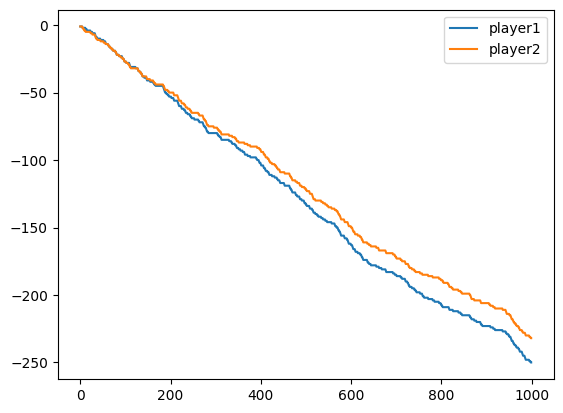

In [23]:
#@title Training
for evolution in range(10):
    print(f"#### Evolution {evolution+1}")
    result = offpolicy_trainer(
        policy=train_policies,
        train_collector=train_collector,
        test_collector=test_collector,
        max_epoch=20,
        step_per_epoch=1000,
        step_per_collect=50,
        episode_per_test=100,
        batch_size=64,
        train_fn=train_fn,
        test_fn=test_fn,
        stop_fn=stop_fn,
        save_best_fn=save_best_fn,
        update_per_step=0.1,
        test_in_train=False,
        reward_metric=reward_metric,
        logger=logger
    )

    model_save_path2 = os.path.join("log", "hommul", "dqn", "policy2.pth")
    if not hasattr(train_policies.policies[agents[0]], 'nolearn'):
        train_policies.policies[agents[0]].load_state_dict(torch.load(model_save_path2))
        train_policies.policies[agents[1]].load_state_dict(torch.load(model_save_path2))

    result = test_collector.collect(n_episode=1000)
    arr = result["rews"]
    interval_size = 100
    num_intervals = episodes // interval_size

    means = []
    std_devs = []

    for i in range(0, episodes, interval_size):
        interval_data = arr[i:i+interval_size]
        mean = np.mean(interval_data, axis=0)
        means.append(mean)

    for i in range(num_intervals - 1):
        mean_diff = means[i+1] - means[i]
        std_devs.append(mean_diff)

    avg = (np.mean(arr, axis=0)) * -100
    std_dev = np.std(std_devs, axis=0) * 100

    print("#"*10)
    print()
    print(f"death rate (in %) of player1: {avg[0]:.1f} +- {std_dev[0]:.3f}")
    print(f"death rate (in %) of player2: {avg[1]:.1f} +- {std_dev[1]:.3f}")
    plt.plot(arr.cumsum(axis=0))
    plt.legend(("player1", "player2"))
    plt.show()

    print()

In [25]:
#@title Save Policy as CSV

df = []
obs = []

for days_left in range(1, env.num_days):
    for player1_life_points in range(1, env.num_life_points):
        for player2_life_points in range(1, env.num_life_points):
            for payoff in [0.2, 0.4]:
                curr_obs = [
                    days_left, 
                    player1_life_points, 
                    player2_life_points, 
                    payoff,
                    payoff
                ]
                obs.append({
                    'agent_id': 'player2',
                    'obs': np.array([curr_obs], dtype='float32'),
                    'mask': [True, True, False]
                })
                df.append(curr_obs)

cols = [
    "days_left", 
    "player1_life_points", 
    "player2_life_points", 
    "player1_prob_payoff",
    "player2_prob_payoff"
]
df = pd.DataFrame(df, columns=cols)

scaler = MinMaxScaler(feature_range=(0, 1))

df["player2_predicted_action"] = train_policies.policies[agents[1]](Batch(obs=obs, info={})).act
df["player2_logit_wait"] = train_policies.policies[agents[1]](Batch(obs=obs, info={})).logits.detach().cpu().numpy()[:, 0]
df["player2_logit_play"] = train_policies.policies[agents[1]](Batch(obs=obs, info={})).logits.detach().cpu().numpy()[:, 1]
df["player2_logit_diff"] = scaler.fit_transform((df["player2_logit_play"] - df["player2_logit_wait"]).values[:, None])

df["player2_predicted_action"] = df["player2_predicted_action"].map({0: "wait", 1: "play"})

df.to_csv("outcome_table.csv", index=False)

df.head()

,days_left,player1_life_points,player2_life_points,player1_prob_payoff,player2_prob_payoff,player2_predicted_action,player2_logit_wait,player2_logit_play,player2_logit_diff
0,1,1,1,0.2,0.2,play,-13.306664,-13.222314,0.635688
1,1,1,1,0.4,0.4,play,-13.752058,-13.681378,0.629523
2,1,1,2,0.2,0.2,wait,-12.925547,-12.965901,0.579447
3,1,1,2,0.4,0.4,wait,-13.200659,-13.291486,0.556685
4,1,1,3,0.2,0.2,wait,-12.828230,-12.892140,0.568824


In [26]:
#@title Visualize policy (mean gameplay)
(df["player2_predicted_action"] == "play").mean()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0.5859375

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


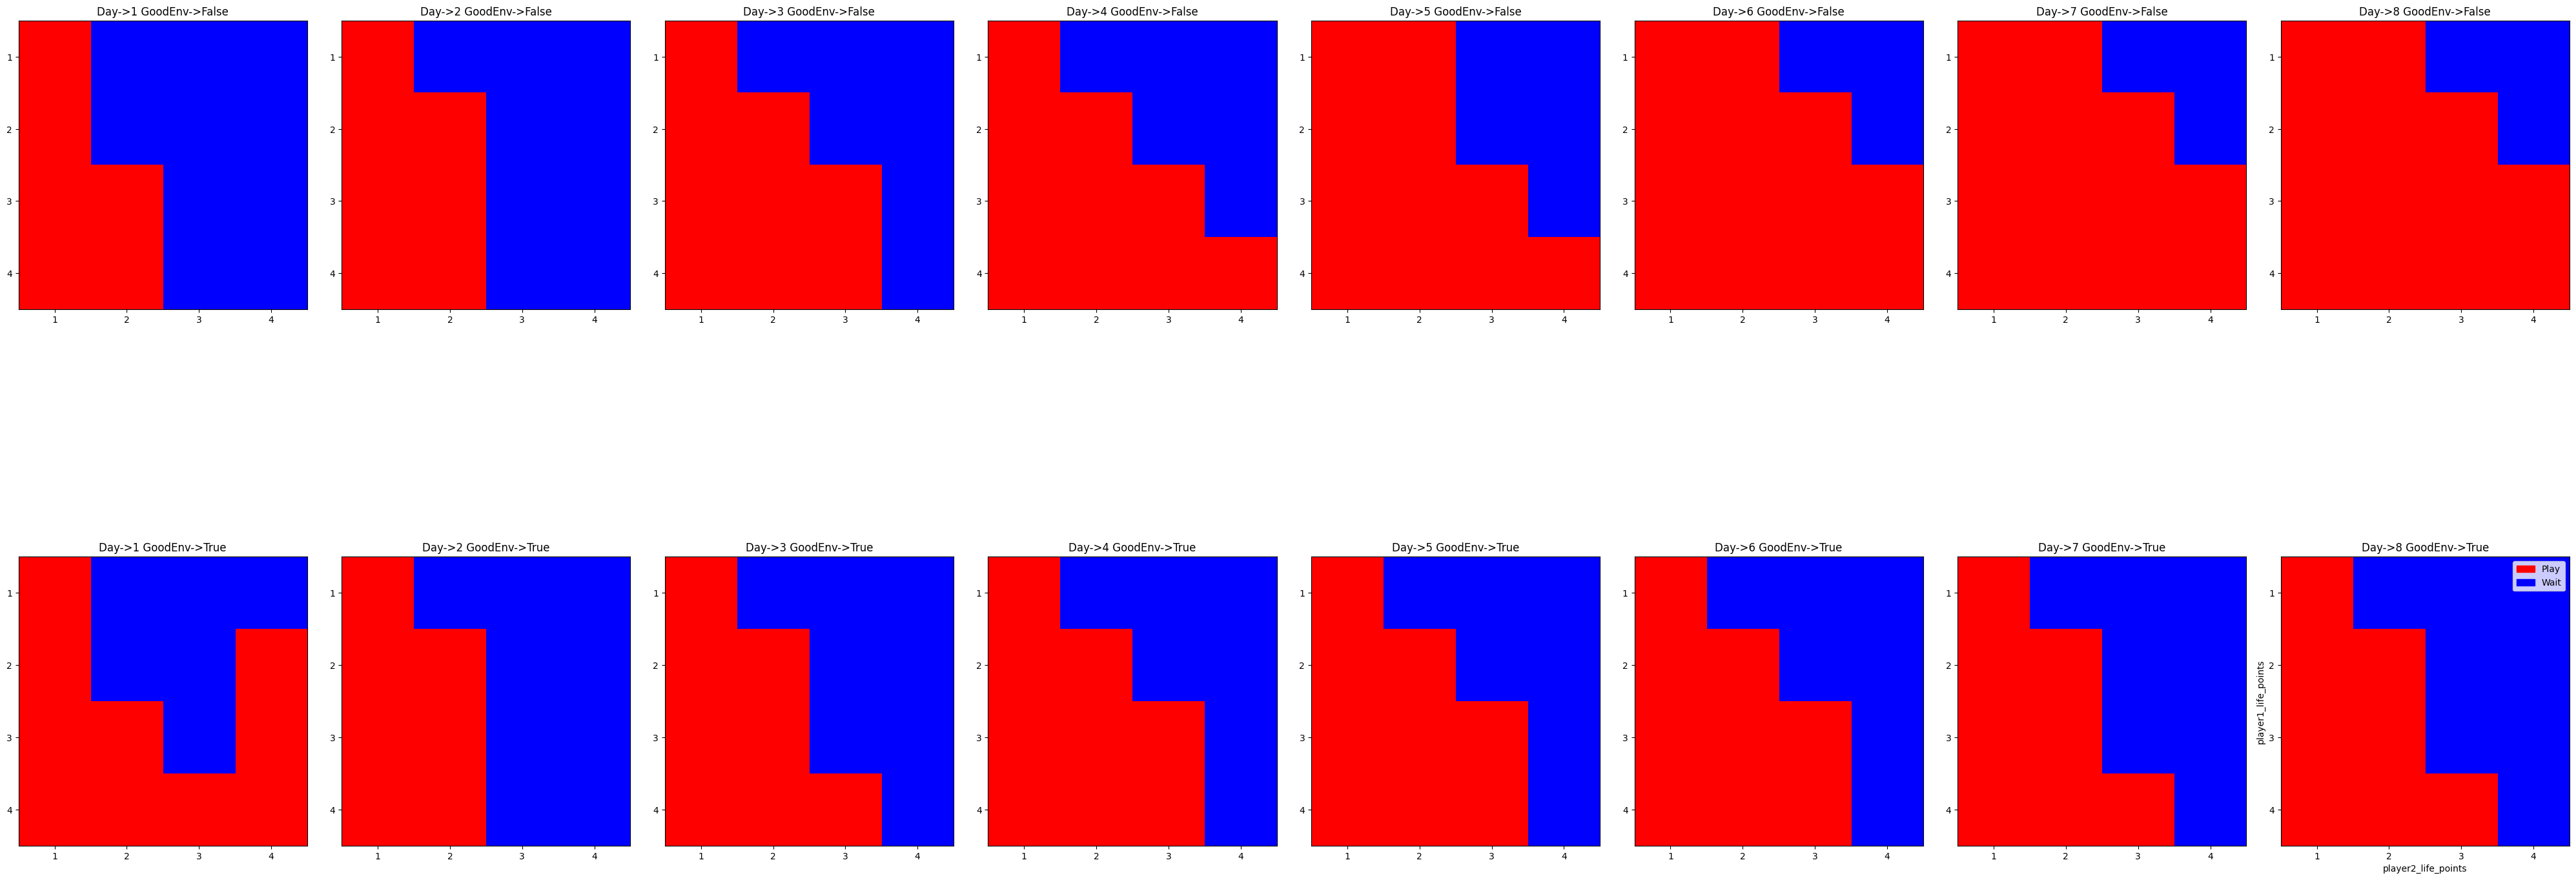

In [28]:
#@title Visualize policy
##TODO display logits instead
fig, axes = plt.subplots(2, 8, figsize=(40, 20))

def _get_im(ax, days_left, is_env_good):
    if is_env_good:
        prob_succ = 0.2
    else:
        prob_succ = 0.4

    arr = df.loc[
        (df["days_left"] == days_left) & 
        (df["player1_prob_payoff"] == prob_succ), 
        "player2_predicted_action"
    ].map({"wait": 0, "play": 1}).values

    ax.imshow(np.reshape(arr, (4, 4)), cmap='bwr')
    ax.set_title(f"Day->{days_left} GoodEnv->{is_env_good}")
    ax.set_xticks(np.arange(0, 4, 1), np.arange(1, 5, 1))
    ax.set_yticks(np.arange(0, 4, 1), np.arange(1, 5, 1))

for idx, ax in enumerate(np.ravel(axes)):
    if idx < 8:
        is_env_good=False
    else:
        is_env_good=True
    days_left = idx%8 + 1
    
    _get_im(ax, days_left=days_left, is_env_good=is_env_good)

ax.set_xlabel("player2_life_points")
ax.set_ylabel("player1_life_points")

red_patch = mpatches.Patch(color='red', label='Play')
blue_patch = mpatches.Patch(color='blue', label='Wait')

plt.legend(handles=[red_patch, blue_patch])

fig.tight_layout()
plt.show()